In [1]:
%%html
<style>
div.optional {
    display: block;
    background-color: #d7e2ff;
    border-color: #d7e2ff;
    border-left: 5px solid #d7e2ff;
    padding: 0.5em;
}
div.advanced {
    display: block;
    background-color: #fff4d7;
    border-color: #fff4d7;
    border-left: 5px solid #fff4d7;
    padding: 0.5em;
}
</style>

In [2]:
import time
start = time.time()
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# the following allows us to plot triangles indicating convergence order
from mpltools import annotation
import scipy.interpolate as si
import scipy.linalg as sl
from matplotlib import rcParams
# For 3D plotting
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri
# font sizes for plots
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Dejavu Sans']

Definitions that will be used throughout:
- Stability is the inevitable discretisation errors that occur over a single time step or are localised to a single part of the spatial domain, do not accumulate such said the quality and convergence of the overall numerical solver is compromised.
- Local truncation error is defined by substituting the exact solution to the PDE into the numerical scheme.
- Local error is error committed by the numerical method in one time step, the local truncation error multiplied by the timestep.
- Consistency refers to the quantitative measure of the extent to which the exact solution satisfies the discretised PDE.
- Convergence of the numerical scheme to the exact solution depends on both consistency and stability.
- Residual error is also the truncation error. It is the error that signals the extent of which the exact solution fits the discrete equations.

QUESTION 1

In [3]:
def RK2_alpha(f, y0, t0, t_max, dt, alpha=0.5):
    """
    Returns coordinates relating to a first order
    numerical approximation for solving an ODE with 
    an intial value y0 at t0 and variable alpha. Error
    of this method has a magnitude of 2.
    
    """
    # assertions that any variable related to time is non-negative
    assert t_max > 0
    assert t0 >= 0
    assert dt > 0
    #intialising values and arrays
    y = np.array(y0)
    t = np.array(t0)
    y_all = [y0]
    t_all = [t0]
    #while loop to calculate at different timesteps
    while t < t_max:
        k1 = f(t, y)
        k2 = f(t + alpha * dt, y + alpha * dt * k1)
        y = y + (1 - (0.5*(alpha**-1))) * dt*k1 + (0.5*alpha**-1)*dt*k2
        y_all.append(y)
        t = t + dt
        t_all.append(t)
    assert len(y_all) == len(t_all)        
    return np.array(y_all), np.array(t_all)    

Runge-Kutta-2 (RK2) method uses intermediate steps in between $t_n$ and $t_{n+1}$ evaluated on the right hand side (RHS) of any given function with varying alpha values.

In [4]:
def forward_euler(f, y0, t0, t_max, dt):
    """
    Returns coordinates relating to a first order
    numerical approximation for solving an ODE with 
    an intial value y0 at t0. Error of this method
    has a magnitude of 1
    """
    # assertions that any variable related to time is non-negative
    assert t_max > 0
    assert t0 >= 0
    assert dt > 0
    #intialising values and arrays
    y = np.array(y0)
    t = np.array(t0)
    y_all = [y0]
    t_all = [t0]
    #while loop to calculate at different timesteps
    while t < t_max:
        y = y + dt*f(t, y)  # euler guess
        y_all.append(y)
        t = t + dt
        t_all.append(t)
    assert len(y_all) == len(t_all)    
    return np.array(y_all), np.array(t_all)

Forward Euler method uses only steps evaluated at $t_n$ and $t_{n+1}$ on the RHS of the function to calculate  $y_{n+1}$

In [5]:
def improved_euler(f, y0, t0, t_max, dt):
    """
     Returns coordinates relating to a first order
    numerical approximation for solving an ODE with 
    an intial value y0 at t0. Error
    of this method has a magnitude of 2.
    """
    # assertions that any variable related to time is non-negative
    assert t_max > 0
    assert t0 >= 0
    assert dt > 0
    #intialising values and arrays
    y = np.array(y0)
    t = np.array(t0)
    y_all = [y0]
    t_all = [t0]
    #while loop to calculate at different timesteps
    while t < t_max:
        ye = y + dt*f(t, y)  # euler guess
        y = y + 0.5*dt* ( f(t, y) + f(t + dt, ye) )
        y_all.append(y)
        t = t + dt
        t_all.append(t)
    assert len(y_all) == len(t_all)      
    return np.array(y_all), np.array(t_all)

improved_euler method uses intermediate steps in between $t_n$ and $t_{n+1}$ evaluated on the right hand side (RHS) of any given function.

In [6]:
def f(t, y):
    assert t >= 0
    #Differential equation to numerically solve
    return y + t**3

In [7]:
def y_ex(t):
    #assert t >= 0
    # Exact solution to differential equation to compare our numerical solvers to
    return 7*np.exp(t) - t**3 - 3*t**2 - 6*t - 6

In [8]:
# Using assert statements to show that when alpha = 1.0 
# the runge-kutta-2 method produces equivalent y values to improved euler given initial condition and time step are the same
yall, tall = improved_euler(f, 1, 0, 3, 0.4)
y_all, t_all = RK2_alpha(f, 1, 0, 3, 0.4, alpha=1.0)
assert yall.all() == y_all.all()
assert tall.all() == t_all.all()

Using assert statements to show that when alpha = 1.0 , the runge-kutta-2 method produces equivalent y values to improved euler given initial condition and time step are the same.
\begin{align*}
    y^* &= y_{n} + \Delta t {f}(t_{n},{y}_{n}), \\[10pt]
    y_{n+1} &= y_{n} + \frac{1}{2} \Delta t \left({f}(t_{n},{y}_{n}) + {f}(t_{n+1},{y}^*)\right).
\end{align*}

Above are equations to denote the Improved Forward Euler method. If alpha is equal to 1.0 in the runge-kutta-2 method then the weighting of the value from the derivative towards $y_{n+1}$ is the same. That is if alpha = 1.0 the equations are identical as shown below
\begin{align*}
k_1 & =  f(t_n, y_n), \\[10pt]
k_2 & =  f(t_n + \alpha \Delta t, y_n + \alpha\,\Delta t\, k_1), \\[10pt]
y^* &= y_{n} + \Delta t {f}(t_{n},{y}_{n}), \\[10pt]
y_{n+1} &= y_n + \left( 1 - \frac{1}{2\alpha}\right)\, \Delta t\, k_1 + 
 \frac{1}{2\alpha} \, \Delta t\, k_2. \\[10pt]
y_{n+1} &= y_n + \left(1-\frac{1}{2}\right)\, \Delta t\, f(t_n, y_n) +
\frac{1}{2} \, \Delta t\ f(t_n +  \Delta t, y_n + \,\Delta t\, f(t_n, y_n)) \\[10pt]
y_{n+1} &= y_n + \left(\frac{1}{2}\right)\, \Delta t\, f(t_n, y_n) +
\frac{1}{2} \, \Delta t\ f(t_n +  \Delta t, y^*) \\[10pt]
y_{n+1} &= y_{n} + \frac{1}{2} \Delta t \left({f}(t_{n},{y}_{n}) + {f}(t_{n+1},{y}^*)\right)
\end{align*}

In [9]:
def approx_error(dt, t_max):
    # assertions that any variable related to time is non-negative
    assert dt > 0
    assert t_max > 0
    uall, tall = RK2_alpha(f, 1., 0., t_max, dt, alpha=0.5)
    err1 = abs(uall[-1]- y_ex(tall[-1]))
    uall, tall = RK2_alpha(f, 1., 0., t_max, dt, alpha=1.0)
    err2 = abs(uall[-1]- y_ex(tall[-1]))
    uall, tall = RK2_alpha(f, 1., 0., t_max, dt, alpha=1.5)
    err3 = abs(uall[-1]- y_ex(tall[-1]))
    uall, tall = RK2_alpha(f, 1., 0., t_max, dt, alpha=3.0)
    err4 = abs(uall[-1] - y_ex(tall[-1]))
    
    return err1, err2, err3, err4

The above function approx_error returns the error at the final time value tall[-1] for varying alpha values. At alpha = 1.0 ,  RK2 is the same as the improved euler method as proven above. If alpha = 0.5 then RK2 is equivalent to the  explicit midpoint method. uall[-1] refers to the y value at the final time value using the RK2 method. The returned error is the absolute difference between the final numerical value and the the exact y value at the same end time. The function returns said errors over a range of varying alpha with all the other initial conditions remaining the same.

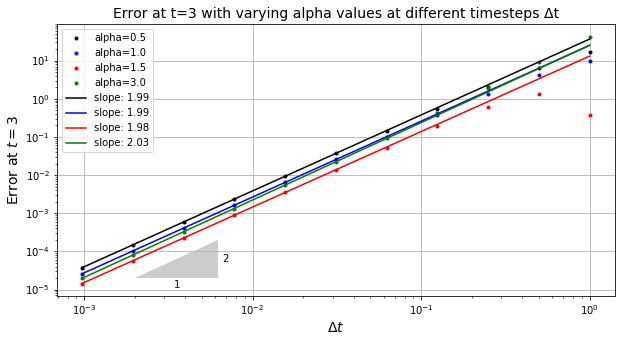

In [10]:
# empty lists to store errors from using RK2 at different alpha values.
error_alpha_1 = []
error_alpha_2 = []
error_alpha_3 = []
error_alpha_4 = []
# create empty dt_array to store Δt over time.
dt_array = []
# Intial Δt
dt = 1.
#while loop to calculate errors at different timesteps
while dt > 5.e-4:
    dt_array.append(dt)
    err1, err2, err3, err4 = approx_error(dt, 3.)
    error_alpha_1.append(err1)
    error_alpha_2.append(err2)
    error_alpha_3.append(err3)
    error_alpha_4.append(err4)
    dt *= 0.5

assert(len(dt_array) == len(error_alpha_1))
assert(len(error_alpha_1) == len(error_alpha_2))
assert(len(error_alpha_2) == len(error_alpha_3))
assert(len(error_alpha_3) == len(error_alpha_4))
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
# fitting the errors against Δt on a log-log graph so the function is linear and thus the slope can be easily calculated.
ax1.loglog(dt_array, error_alpha_1, 'k.', label='alpha=0.5')
ax1.loglog(dt_array, error_alpha_2, 'b.', label='alpha=1.0')
ax1.loglog(dt_array, error_alpha_3, 'r.', label='alpha=1.5')
ax1.loglog(dt_array, error_alpha_4, 'g.', label='alpha=3.0')

ax1.set_xlabel('$\Delta t$', fontsize=14)
ax1.set_ylabel('Error at $t=3$', fontsize=14)
ax1.set_title('Error at t=3 with varying alpha values at different timesteps Δt', fontsize=14)
ax1.grid(True)

start_fit = 4
# Fits a polynomial of degree 1 between dt_array(indepedent) and error_alpha(depedent). Returns coefficients of said polynominal
line_fit_a1 = np.polyfit(np.log(dt_array[start_fit:]), np.log(error_alpha_1[start_fit:]), 1)
line_fit_a2 = np.polyfit(np.log(dt_array[start_fit:]), np.log(error_alpha_2[start_fit:]), 1)
line_fit_a3 = np.polyfit(np.log(dt_array[start_fit:]), np.log(error_alpha_3[start_fit:]), 1)
line_fit_a4 = np.polyfit(np.log(dt_array[start_fit:]), np.log(error_alpha_4[start_fit:]), 1)
# Plots the straight line polynomial on same ax1 log-log scale
ax1.loglog(dt_array, np.exp(line_fit_a1[1]) * dt_array**(line_fit_a1[0]), 'k-', label = 'slope: {:.2f}'.format(line_fit_a1[0]))
ax1.loglog(dt_array, np.exp(line_fit_a2[1]) * dt_array**(line_fit_a2[0]), 'b-', label = 'slope: {:.2f}'.format(line_fit_a2[0]))
ax1.loglog(dt_array, np.exp(line_fit_a3[1]) * dt_array**(line_fit_a3[0]), 'r-', label = 'slope: {:.2f}'.format(line_fit_a3[0]))
ax1.loglog(dt_array, np.exp(line_fit_a4[1]) * dt_array**(line_fit_a4[0]), 'g-', label = 'slope: {:.2f}'.format(line_fit_a4[0]))
#Produces the triangles to demonstrate gradient of varying alpha values for RK2
annotation.slope_marker((2e-3, 2e-5), (2, 1), ax=ax1, size_frac=0.15, pad_frac=0.05)


ax1.legend(loc='best')


Above we can see the error at t=3 plotted against Δt for the RK2 method with different alpha values. Although difficult to graphically see, on closer inspection, when alpha is 3.0 the error between $10^{0}$ and $10^{-0.5}$ overlaps the plot for alpha for 1.0. With smaller values of Δt, it diverges from similarity of when alpha = 1.0, sitting between slopes alpha = 1.5 and alpha = 1.0 when Δt approximately equals $10^{-3}$. This is what we would expect as the gradient of the green slope (alpha = 3.0) is 2.03 which is steeper than that for blue slope (alpha = 1.0). Error does not necessarily decrease with increasing alpha values as when alpha = 1.5 it has the smallest errors across all Δt compared to the other alpha values which includes lower ones such 0.5, 1.0 and higher ones like 3.0. Regardless of the value of alpha, as Δt gets increasingly smaller the error converges to a bracket between the range of $10^{-4}$ and $10^{-5}$. 

RK2 can be expressed by the following equation:
$$ y_{n+1} = y_n + \Delta t\, f_n + \frac{\Delta t^2}{2!}(f_{t_n} + f_n \, f_{y_n}) + \mathcal{O}(\Delta t^3), $$

where $\mathcal{O}(\Delta t^3), $ is the local truncation error. The global error plotted against varying Δt. The slope of 2 is predicted due to the highest order leading term in RK2 is $\Delta t^p$ where q=2. While, decreasing Δt to a smaller positive number, the errors converge, with truncation error getting smaller, and depending on the problem the round off error. However, in the limit as Δt tends to 0, the truncation errors also tends to 0. Thus by definition, technically, the limit tends to the exact solution and so the method is termed 'consistent'.


When alpha is 1.5, at Δt = $10^{0}$ the error is lower than that for error related to the next timestep. It could potentially be a bug in the code or perhaps a consequence of instability.

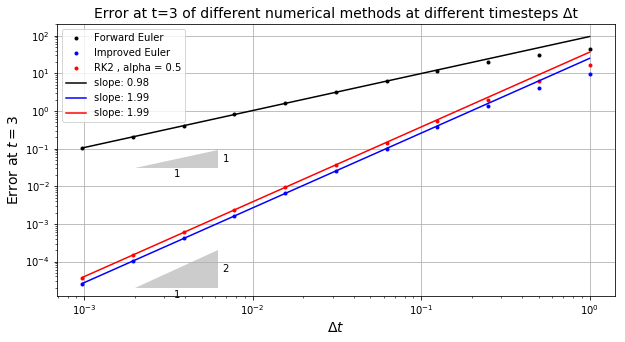

In [11]:
# empty lists to store errors from using RK2 at different alpha values.
error_fe = []
error_ie = []
error_rk2 = []
# create empty dt_array to store Δt over time.
dt_array = []
# Intial Δt
dt = 1.
def approx_error_methods(dt, t_max):
    """
    Returns error between numerical and exact
    at the last timestep for different numerical-
    methods.
    """
    yall, tall = forward_euler(f, 1, 0, t_max, dt)
    err1 = abs(yall[-1]-y_ex(tall[-1]))
    yall, tall = improved_euler(f, 1, 0, t_max, dt)
    err2 = abs(yall[-1]-y_ex(tall[-1]))
    yall, tall = RK2_alpha(f, 1, 0, t_max, dt)
    err3 = abs(yall[-1]-y_ex(tall[-1]))
    return err1, err2, err3
#while loop to calculate errors at different timesteps
while dt > 5.e-4:
    dt_array.append(dt)
    err1, err2, err3 = approx_error_methods(dt, 3)
    error_fe.append(err1)
    error_ie.append(err2)
    error_rk2.append(err3)
    dt *= 0.5

assert(len(dt_array) == len(error_fe))
assert(len(error_fe) == len(error_ie))
assert(len(error_ie) == len(error_rk2))
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
# fitting the errors against Δt on a log-log graph so the function is linear and thus the slope can be easily calculated.
ax1.loglog(dt_array, error_fe, 'k.', label='Forward Euler')
ax1.loglog(dt_array, error_ie, 'b.', label='Improved Euler')
ax1.loglog(dt_array, error_rk2, 'r.', label='RK2 , alpha = 0.5')

ax1.set_xlabel('$\Delta t$', fontsize=14)
ax1.set_ylabel('Error at $t=3$', fontsize=14)
ax1.set_title('Error at t=3 of different numerical methods at different timesteps Δt', fontsize=14)
ax1.grid(True)


start_fit = 4
# Fits a polynomial of degree 1 between dt_array(indepedent) and error(depedent). Returns coefficients of said polynominal
line_fit_fe = np.polyfit(np.log(dt_array[start_fit:]), np.log(error_fe[start_fit:]), 1)
line_fit_ie = np.polyfit(np.log(dt_array[start_fit:]), np.log(error_ie[start_fit:]), 1)
line_fit_rk2 = np.polyfit(np.log(dt_array[start_fit:]), np.log(error_rk2[start_fit:]), 1)
# Plots the polynomial on same ax1 log-log scale
ax1.loglog(dt_array, np.exp(line_fit_fe[1]) * dt_array**(line_fit_fe[0]), 'k-', label = 'slope: {:.2f}'.format(line_fit_fe[0]))
ax1.loglog(dt_array, np.exp(line_fit_ie[1]) * dt_array**(line_fit_ie[0]), 'b-', label = 'slope: {:.2f}'.format(line_fit_ie[0]))
ax1.loglog(dt_array, np.exp(line_fit_rk2[1]) * dt_array**(line_fit_rk2[0]), 'r-', label = 'slope: {:.2f}'.format(line_fit_rk2[0]))
# Produces the triangles to demonstrate gradient of different numerical methods.
annotation.slope_marker((2e-3, 3e-2), (1, 1), ax=ax1, size_frac=0.15, pad_frac=0.05)
annotation.slope_marker((2e-3, 2e-5), (2, 1), ax=ax1, size_frac=0.15, pad_frac=0.05)


ax1.legend(loc='best')

The forward euler can be seen as an expansion of the taylor series with a  local truncation error (LTE) of $\mathcal{O}(\Delta t^2), $ while the improved euler has a LTE of $\mathcal{O}(\Delta t^3) $.
The RK2 can also be be seen as an expansion of the taylor series with a LTE of $\mathcal{O}(\Delta t^3), $ as described previously. LTE is not a reliable indication of the global error and thus the error plotted relates to that of the global error $ |{y(t_{n})-y_{n}}|$. Local errors are defined by $ {\Delta t}({\text{LTE}})$. For forward euler, the local error has an accuracy of $\Delta t^2$, while for RK2 and improved euler it is $\Delta t^3$.  Given the parameters chosen, all 3 methods are stable and thus the global error is one power of $\Delta t$ lower.
Hence, the degree of accuracy given by $ \Delta t^q$ is q=1 for forward euler, while q=2 for RK2 and improved euler. This is demonstrated above where slope is equivalent to q and so the theoretical accuracy for each method matches that of the plotted slopes.
For all methods it is seen that as Δt becomes increasingly smaller, the error at t=3 decreases. As stated before, due to the associated error slopes of RK2 and improved Euler, the error decreases at a faster rate compared to forward euler with the Δt.

The divergence of the methods presented above not only depend on $\Delta t$ but the second derivative of the exact solution. Improved Euler and RK2 use the average tangent slope between two time points given by:
\begin{align*}
\frac{1}{2}({f}(t_{n},{y}_{n}) + {f}(t_{n+1},{y}^*))\\[10pt]
\end{align*}
Therefore, this reduces the error when the derivative rapidly changes upon perturbation of the indepedent variables as these methods take the average of the slopes.

All three methods are said to converge to 0 as Δt tends to 0 as they have a convergence order p>0. It is evident from the graph that a higher p number indicates a faster convergence with improved Euler and RK2 (alpha=0.5) being superior methods compared to forward euler.

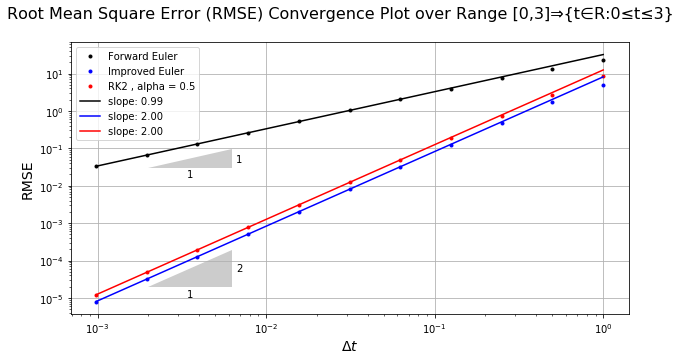

In [12]:
# empty lists to store errors from using RK2 at different alpha values.
error_fe = []
error_ie = []
error_rk2 = []
# create empty dt_array to store Δt over time.
dt_array = []
# Intial Δt
dt = 1.
 
def rmse(numerical_approximation, exact):
    """
    Returns the square root of the mean of 
    the difference squared
    """
    return np.sqrt(((numerical_approximation[:] - exact[:]) ** 2).mean())

def approx_range(dt, t_max):
    """
    Returns the RMSE of different
    numerical methods
    """
    assert dt >= 0
    assert t_max > 0
    yall, tall = forward_euler(f, 1, 0, t_max, dt)
    err1 = rmse(yall, y_ex(tall))
    yall, tall = improved_euler(f, 1, 0, t_max, dt)
    err2 = rmse(yall, y_ex(tall))
    yall, tall = RK2_alpha(f, 1, 0, t_max, dt)
    err3 = rmse(yall, y_ex(tall))  
    return err1, err2, err3
#while loop to calculate errors at different timesteps
while dt > 5.e-4:
    dt_array.append(dt)
    err1, err2, err3 = approx_range(dt, 3)
    error_fe.append(err1)
    error_ie.append(err2)
    error_rk2.append(err3)
    dt *= 0.5

assert(len(dt_array) == len(error_fe))
assert(len(error_fe) == len(error_ie))
assert(len(error_ie) == len(error_rk2))
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
fig.suptitle('Root Mean Square Error (RMSE) Convergence Plot over Range [0,3]⇒{t∈R:0≤t≤3}', fontsize=16)
# fitting the errors against Δt on a log-log graph so the function is linear and thus the slope can be easily calculated.
ax1.loglog(dt_array, error_fe, 'k.', label='Forward Euler')
ax1.loglog(dt_array, error_ie, 'b.', label='Improved Euler')
ax1.loglog(dt_array, error_rk2, 'r.', label='RK2 , alpha = 0.5')

ax1.set_xlabel('$\Delta t$', fontsize=14)
ax1.set_ylabel('RMSE', fontsize=14)
ax1.grid(True)

# use numpy.polyfit to find best fit linear line to data

# what does this parameter do, and what happens if you choose equal to a smaller value
start_fit = 4
# Fits a polynomial of degree 1 between dt_array(indepedent) and error(depedent). Returns coefficients of said polynominal
line_fit_fe = np.polyfit(np.log(dt_array[start_fit:]), np.log(error_fe[start_fit:]), 1)
line_fit_ie = np.polyfit(np.log(dt_array[start_fit:]), np.log(error_ie[start_fit:]), 1)
line_fit_rk2 = np.polyfit(np.log(dt_array[start_fit:]), np.log(error_rk2[start_fit:]), 1)
# Plots the polynomial on same ax1 log-log scale
ax1.loglog(dt_array, np.exp(line_fit_fe[1]) * dt_array**(line_fit_fe[0]), 'k-', label = 'slope: {:.2f}'.format(line_fit_fe[0]))
ax1.loglog(dt_array, np.exp(line_fit_ie[1]) * dt_array**(line_fit_ie[0]), 'b-', label = 'slope: {:.2f}'.format(line_fit_ie[0]))
ax1.loglog(dt_array, np.exp(line_fit_rk2[1]) * dt_array**(line_fit_rk2[0]), 'r-', label = 'slope: {:.2f}'.format(line_fit_rk2[0]))

ax1.legend(loc='best')
annotation.slope_marker((2e-3, 3e-2), (1, 1), ax=ax1, size_frac=0.15, pad_frac=0.05)
annotation.slope_marker((2e-3, 2e-5), (2, 1), ax=ax1, size_frac=0.15, pad_frac=0.05)
    

 The Root mean squared error is given by:  
\begin{align*}                  
RMSE = \sqrt{E ({y_n} - y(t_{n}))^2}
\end{align*}


The root-mean-square is used to measure the difference between the exact and the numerically approximated value. The difference is the error. The RMSE is sensitive to outliers/anomalies as the errors are squared before they are averaged and thus a large error holds a high weight. A high RMSE could potentially indiciate instability in your numerical approximation or poor Δt approximation. A large RMSE means the variance associated with the frequency of error distribution of the magnitude of error also increases. At larger Δt the RMSE is higher for all methods.
RMSE was chosen over other error related functions as it accurately takes into account the propagation of errors as it penalises a value prediction more than another method such as mean average error (MAE). As MAE is robust when it comes to outlier, it could gives a false assurance that your numerical approximation is close to the exact solution while in fact there significant errors.

Forward Euler has a slope of 1 and is the least accurate while improved euler and RK2 (alpha = 0.5) have a slope of 2.
As expected, the RMSE decreases with increasingly small Δt. With smaller Δt, the approximation of tangent line at any point is more accurate to the true tangent line at said point.
Across all Δt the improved euler has a smaller error than RK2. The slopes of the different methods agree with the slopes of the same methods but when taking the error at t=3. However, the line of best fit more accurately fits the relevant data point suggesting taking the RMSE is a better indication of error than taking only the error at a single value t=3. Taking the error at the final time step does not necessarily mean it has the highest error and so a method which takes all data points into account such as RMSE improves accuracy.


The graph shows no visible outliers using the initial condition $ y(0) = 1 $ as the polynomial for a specific method passes through almost all points. The associated slopes of the method also agree with theoretical expectations.

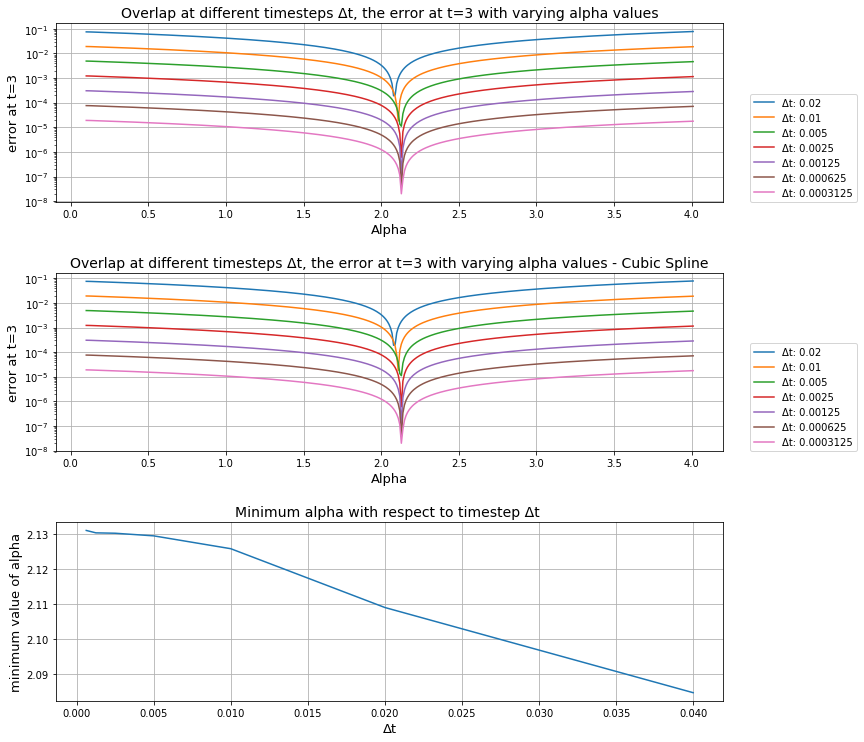

In [13]:
#https://stackoverflow.com/questions/50371298/find-maximum-minimum-of-a-1d-interpolated-function
def quadratic_spline_roots(spl):
    """
    Parameter takes the derivative of
    the cubic spline and thus calculates
    and returns the roots of the 
    quadratic spline
    """
    roots = []
    knots = spl.get_knots()
    for a, b in zip(knots[:-1], knots[1:]):
        u, v, w = spl(a), spl((a + b)/2), spl(b)
        t = np.roots([u + w - 2*v, w - u, 2*v])
        t = t[np.isreal(t) & (np.abs(t) <= 1)]
        roots.extend(t*(b - a)/2 + (b + a)/2)
    return np.array(roots)
# initial conditions
y0 = 1.
t0 = 0.
dt = 0.04
t_max = 3.
#Empty arrays to store timesteps Δt and the minimum alpha values
dt_array = []
min_alpha = []

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))
# No overlap between vertically spaced subplots
fig.tight_layout(h_pad=5) 

def alpha_approx(dt, tmax):
    yall, tall = RK2_alpha(f, y0, t0, t_max, dt, alpha)
    err = abs(yall[-1]- y_ex(tall[-1]))
    return err
#Calculate how change in alpha effects the error for different timesteps, hence two while loops.
while dt > 5.e-4:
    alpha = 0.1
    dt_array.append(dt)
    errs_alpha = [alpha_approx(dt, t_max)]
    track_alpha = [alpha]
    while alpha < 4.0:
        err = alpha_approx(dt, t_max)
        errs_alpha.append(err)
        alpha += 0.01
        track_alpha.append(alpha)
        #track_alpha.append(alpha)
    dt *= 0.5
    # create cubic spline function fi with arrays track_alpha and errs_alpha
    fi = si.InterpolatedUnivariateSpline(track_alpha, errs_alpha, k=3)
    # use the quadratic_spline_roots on the quadratic spline function to determine max and min values.
    cr_pts = quadratic_spline_roots(fi.derivative())
    # check the endpoints of the interval4
    cr_pts = np.append(cr_pts, (track_alpha[0], track_alpha[-1])) 
    # return the indicies of the minimum values
    cr_vals = fi(cr_pts)
    min_index = np.argmin(cr_vals)
    # changes y-axis to log scaling
    ax2.semilogy(track_alpha, fi(track_alpha), label='Δt: {0}'.format(dt))
    ax1.semilogy(track_alpha, errs_alpha, label = 'Δt: {0}'.format(dt) )
    # list to track minimum alpha values.
    min_alpha.append(cr_pts[min_index])

assert(len(dt_array) == len(min_alpha))
assert(len(errs_alpha) == len(track_alpha))

ax3.plot(dt_array,min_alpha)

ax1.legend(loc = (1.04,0))
ax2.legend(loc = (1.04,0))
ax1.set_xlabel('Alpha', fontsize=13)
ax1.set_ylabel('error at t=3', fontsize=13)
ax2.set_xlabel('Alpha', fontsize=13)
ax2.set_ylabel('error at t=3', fontsize=13)
ax3.set_xlabel("Δt", fontsize=13)
ax3.set_ylabel("minimum value of alpha", fontsize=13)

ax2.set_title('Overlap at different timesteps Δt, the error at t=3 with varying alpha values - Cubic Spline', fontsize=14)
ax1.set_title('Overlap at different timesteps Δt, the error at t=3 with varying alpha values', fontsize=14)
ax3.set_title('Minimum alpha with respect to timestep Δt ', fontsize=14)

ax1.grid(True)
ax2.grid(True)
ax3.grid(True)


    
    
    
    
    
    


The first graph - 'Overlap at different timesteps Δt, the error at t=3 with varying alpha values' displays how the error at t=3, varies as alpha does for different steps. The individual curves on the plot each demonstrate that there is a value alpha where the error is minimised. On either side of the minimum, as alpha increases or decreases from that point, the errors rises. This complies with the error plot prior that increasing alpha does not necessairly lead to a smaller error and from said error plot it could be estimated that the minimum alpha value be in the range of 1.5-3.0 .

The second graph - 'Overlap at different timesteps Δt, the error at t=3 with varying alpha values - Cubic Spline' is a plot of a cubic spline function for the data as appears on the x and y axis. The cubic spline function can be used to calculate the derivative (quadratic spline) to work out the corresponding alpha value when said derivative = 0. It can be seen on both graph 1 and 2 that as Δt gets smaller the derivative around the minimum is larger. Visually, for larger Δt the graph appears smoother around the minimum point whilst sharper for smaller Δt.

The third graph - 'Minimum alpha with respect to timestep Δt highlights how the minimum alpha value of a cubic spline function increases with decreasing timestep Δt. At smaller Δt, the more accurate the numerical approximation with reference to the exact solution. The curve demonstrates linearity between the range of 0.020-0.040 Δt. However, for values not in this range the gradient changes, increasing until Δt = 0.010 until it starts to converge to a value of minimum value of alpha of 2.13. The apparent flick of the curve on approach of Δt could potentially be due to a round off error.
    

Cubic spline was used to interpolate the dataset to avoid the problem that occurs with Runge's phenomenon. With an increasing data set N+1 with a polynomial of degree N, the polynomial becomes large and costly to differentiate . The cubic spline interpolation, reduces interpolation error compared to other interpolating polynomials such as the Lagrange or Newton polynomial as it is a piecewise polynomial. Also, the cubic spline interpolation is faster to differentiate and find the minimum values in this case compared to the other polynomial methods mentioned.

 CONCLUSION FOR Q1

- All methods become more accurate with a smaller Δt.


- Methods which use more derivative approximations such as RK2, improved euler result in an a higher order of accuracy. RK2 has a greater stability region than forward euler and in almost all cases is a more suitable option than forward euler.

- The stiffness of the equations result in instability unless Δt is very small. Therefore, it should be solved with implicit methods to avoid using a very small Δt.

- RK2 and improved euler become increasingly more accurate compared to forward euler at t=3 and for the RMSE across the range t[0:3]. The slope for both comparisons was 1 for forward euler and 2 for RK2 and improved euler. Depending on the degree of accuracy required, using RK2 and improved euler and a larger Δt could very well be cheaper than the forward euler and a smaller timestep. An analysis could be done to find the optimum required tolerance of accuracy and time taken for cell execution.

- With all alpha values being in the range 2.14- 2.09 it suggests based on the equations:
\begin{align*}
k_1 & =  f(t_n, y_n), \\[10pt]
k_2 & =  f(t_n + \alpha \Delta t, y_n + \alpha\,\Delta t\, k_1), \\[10pt]
y_{n+1} &= y_n + \left( 1 - \frac{1}{2\alpha}\right)\, \Delta t\, k_1 + 
 \frac{1}{2\alpha} \, \Delta t\, k_2. \\[10pt]
\end{align*} 
that the RK2 numerical approximation for this ODE is more accurate when, roughly speaking, $y_{n+1}$  is more dependent on the value of $k_1$ (the first derivative) with a weighting of 0.75 while $k_2$ has a weighting of 0.25.


- The minimum alpha value varies slightly when using different Δt, converging roughly to 2.13 as seen in the graph above. The relationship of minimum alpha value and Δt is inversely proportional, with the alpha increasing with decreasing Δt. As Δt decreases, $y_{n+1}$ becomes more so dependent on the value of the derivative $k_{1}$ than $k_{2}$

QUESTION 2

I have included FTCS, BTCS and Crank-Nicolson separately so one can compare against the theta method.

In [14]:
def adv_diff_analytical_solution(U, kappa, x0, x, t):
    """ Analytical solution to advection-diffusion for an assumed 
    Dirac-delta initial condition at t=0.
    """
    return np.exp( -((x-x0) - U * t)**2 / (4. * kappa * t)) / np.sqrt(4. * np.pi * kappa * t)

In [15]:
def plot_eigs_stability(ax, A):
    """ Function to plot the forward Euler stability region and
    overlay it with dt multiplied by the eigenvalues of the matrix
    A in the complex plane.
    """
    A_eigs = np.linalg.eigvals( A )
    ax.set_aspect('equal')
    ax.grid(True)
    ax.set_xlabel(r'$Re(\lambda)\Delta t$', fontsize=14)
    ax.set_ylabel(r'$Im(\lambda)\Delta t$', fontsize=14)
    ax.set_title('Eigenvalues vs stability region', fontsize=14)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    # add in the eigenvalues
    for eig in A_eigs:
        ax.plot(np.real(eig)*dt, np.imag(eig)*dt, 'bo')
    # and the FE stability region
    # we're again going to plot the stability region for forward Euler
    x = np.linspace(-2.5, 0.5, 100)
    y = np.linspace(-1.5, 1.5, 100)
    xx, yy = np.meshgrid(x, y)
    lamdt = xx + 1j*yy
    # forward Euler amplification factor
    amp = 1 + lamdt
    ampmag = np.abs(amp)
    # forward Euler
    ax.contour(x, y, ampmag, [1.0], colors=('k'))
    ax.contourf(x, y, ampmag, (0.0, 1.0), colors=('tab:grey'))

def add_fig_axes_etc(ax):
    ax.set_xlabel('$x/L$', fontsize=16)
    ax.set_ylabel('$C/C_E$', fontsize=16)
    ax.set_title('Adv-Diff time-dependent PDE solve', fontsize=16)
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.1, 1.1)    

In [16]:
# Conditions for diffusion_advection equation 
U = 1.
kappa = 1./100.
N = 500
L = 10.
dx = L / N
dt = 0.01
t_start = 2.
t_end = t_start + 4.
x0 = 1.0
def adv_central_periodic(N):
    """ Funtion to generate the NxN discretisation matrix for advection
    using second-order central differences.
    
    NB. this version does not multiply through by the factor  (U / dx).
    """
    # advection term- essentially storing coefficients of c
    Dx = 0.5*np.eye(N, k=1) - 0.5*np.eye(N, k=-1)
    # Add in the wrapped values due to periodicity
    Dx[0, -1] = -0.5
    Dx[-1, 0] = 0.5
    return Dx
    
def diff_central_periodic(N):
    """ Funtion to generate the NxN discretisation matrix for diffusion
    using second-order central differences.
    
    NB. this version does not multiply through by the factor  (kappa / dx**2).
    """
     # diffusion term- essentially storing coefficients of c
    Dxx = np.eye(N, k=1) - 2*np.eye(N) + np.eye(N, k=-1)
    # Add in the wrapped values due to periodicity
    Dxx[0, -1] = 1.
    Dxx[-1, 0] = 1.
    return Dxx

In [17]:
def solve_adv_diff_Gaussian_FE(N, dt, t_start, t_end, U, kappa):
    """ Solve the advection-diffusion problem on a periodic domain
    with a hard coded Gaussian-shaped initial condition. FTCS method.
    
    Returns:
    C - the solution at all time levels.
    x - the spatial mesh.
    t - the time levels.
    """
    # define spatial mesh
    dx = L / N
    x = np.linspace(0, L, N)
       
    # create discretisation matrix
    Dx = adv_central_periodic(N)
    Dxx = diff_central_periodic(N)
    A = -(U / dx) * Dx + (kappa / dx**2) * Dxx 
    print('Pe_c: {0:.5f}.  Stable: {1}'.format(U*dx/kappa, U*dx/kappa<2))    
    print('CFL:  {0:.5f}.  Stable: {1}'.format(U*dt/dx, U*dt/dx<1.))
    print('r:    {0:.5f}.  Stable: {1}'.format(kappa*dt/(dx**2), kappa*dt/(dx**2)<0.5)) 

    t = np.arange(t_start, t_end + 1e-14, dt)

    C = np.empty((len(x), len(t)))
    
    # define an initial condition
    C[:,0] = adv_diff_analytical_solution(U, kappa, x0, x, t_start)
    I = np.eye(len(x))
    #Identity matrix is matrix equivalent of adding 1
    #Numerically solving the PDE at different times and storing in matrix C, using previous columns in calculation of the next column. FTCS
    for n in range(len(t)-1):
        C[:,n+1] = (I + A * dt) @ C[:,n]   
    return C, x, t 

In [18]:
def solve_adv_diff_Gaussian(N, dt, t_start, t_end, U, kappa):
    """ Solve the advection-diffusion problem on a periodic domain
    with a hard coded Gaussian-shaped initial condition. 
    
    Returns:
    C - the solution at all time levels.
    x - the spatial mesh.
    A - the discretisation matrix
    """
    # define spatial mesh
    dx = L / N
    x = np.linspace(0, L, N) 
    # create discretisation matrix
    Dx = adv_central_periodic(N)
    Dxx = diff_central_periodic(N)
    A = -(U / dx) * Dx + (kappa / dx**2) * Dxx
    print('Pe_c: {0:.5f}.  Stable: {1}'.format(U*dx/kappa, U*dx/kappa<2))    
    print('CFL:  {0:.5f}.  Stable: {1}'.format(U*dt/dx, U*dt/dx<1.))
    print('r:    {0:.5f}.  Stable: {1}'.format(kappa*dt/(dx**2), kappa*dt/(dx**2)<0.5)) 

    t = np.arange(t_start, t_end + 1e-14, dt)

    C = np.empty((len(x), len(t)))
    
    # define an initial condition
    C[:,0] = adv_diff_analytical_solution(U, kappa, x0, x, t_start)
    I = np.eye(len(x))
    #Identity matrix is matrix equivalent of adding 1
    #Numerically solving the PDE at different times and storing in matrix C, using previous columns in calculation of the next column.
    for n in range(len(t)-1):
        C[:,n+1] = (I + A * dt) @ C[:,n]    
    return C, x, A # returning matrix A to calculate eigenvalues and demonstrate stability for FTCS

Pe_c: 2.00000.  Stable: False
CFL:  0.50000.  Stable: True
r:    0.25000.  Stable: True


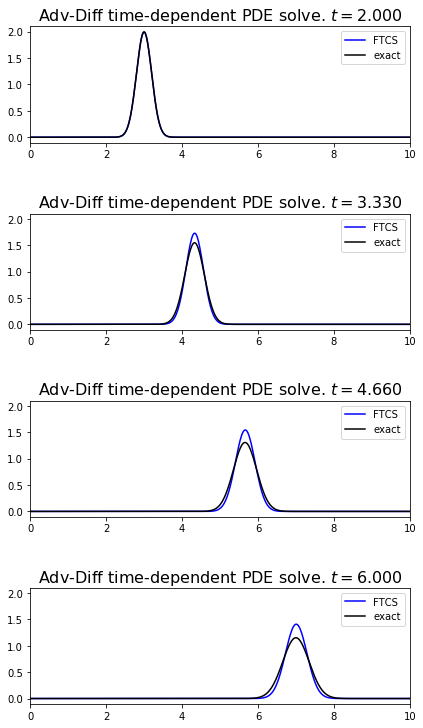

In [19]:
#solve_adv_diff_Gaussian_FE(N, dt, t_start, t_end, U, kappa)
def finite_diff_plotter(method, label, line_graphic):
    C, x, t = method
    xf = np.linspace(0, L, 1000)
    # set up figure
    fig, axs = plt.subplots(4, 1, figsize=(6, 10))
    axs = axs.reshape(-1)
    fig.tight_layout(w_pad=4, h_pad=5)

    for i, n in enumerate(np.linspace(0, C.shape[1]-1, 4, dtype=int)):
        c = adv_diff_analytical_solution(U, kappa, x0, xf, t[n])
        axs[i].plot(x, C[:,n], line_graphic, label=label)
        axs[i].plot(xf, adv_diff_analytical_solution(U, kappa, x0, xf, t[n]), 'k-', label='exact')
        axs[i].legend(loc='best')
        axs[i].set_xlim(0.0, 10.0)
        axs[i].set_ylim(-0.1, 2.1)
        axs[i].set_title('Adv-Diff time-dependent PDE solve. $t=${0:.3f}'.format(t[n]), fontsize=16)
finite_diff_plotter(solve_adv_diff_Gaussian_FE(N, dt, t_start, t_end, U, kappa), 'FTCS', 'b-')        

The errors propagate over time as shown by the overlapping the exact graph and the numerical approximation. As time increases, the overlap gets visibily worse, with it over estimating the c values.

Pe_c: 2.00000.  Stable: False
CFL:  0.50000.  Stable: True
r:    0.25000.  Stable: True

Check for undershoots: 1.97020e-266


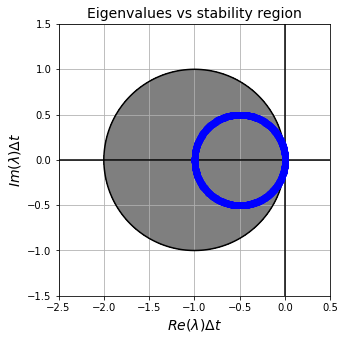

In [20]:
C, x, A = solve_adv_diff_Gaussian(N, dt, t_start, t_end, U, kappa)

# set up figure
fig, axs = plt.subplots(figsize=(10, 5))


plot_eigs_stability(axs, A)
print('\nCheck for undershoots: {0:.5e}'.format(np.min(C)))

The Cell peclet number condition here is not met as it has a value of 2 which indicates instability. The CFL and r-parameter condition however are satisfied. The blue dotted circle shows the eigenvalues of the discretisation matrix A multiplied by the chosen timestep in the complex plane. The grey circle is the stable region for forward euler. The eigenvalues appear to all be within the absolutue stability region, however given we know the cell peclet number is unstable as it has to be less than 2 this is not the case. On the other hand, it is just above the bounded value and so error propagation caused by instability is very small. The undershoot value is small albeit positive and thus don't grow fast and has little impact in this case. To fix the cell peclet number we could use a smaller $\Delta x$.

In [21]:
def solve_adv_diff_Gaussian_BE(N, dt, t_start, t_end, U, kappa):
    """ Solve the advection-diffusion problem on a periodic domain
    with a hard coded Gaussian-shaped initial condition. BTCS method
    
    Returns:
    C - the solution at all time levels.
    x - the spatial mesh.
    t - the time levels.
    """
    # define spatial mesh
    dx = L / N
    x = np.linspace(0, L, N)
       
    # create discretisation matrix
    Dx = adv_central_periodic(N)
    Dxx = diff_central_periodic(N)
    A = -(U / dx) * Dx + (kappa / dx**2) * Dxx

    t = np.arange(t_start, t_end + 1e-14, dt)

    C = np.empty((len(x), len(t)))
    
    # define an initial condition
    C[:,0] = adv_diff_analytical_solution(U, kappa, x0, x, t_start)
    #Identity matrix is matrix equivalent of adding 1
    #
    I = np.eye(len(x))
    #Numerically solving the PDE at different times and storing in matrix C, using previous columns in calculation of the next column. BTCS
    for n in range(len(t)-1):
        C[:,n+1] = np.linalg.solve((I - A*dt), C[:,n]) 
    return C, x, t

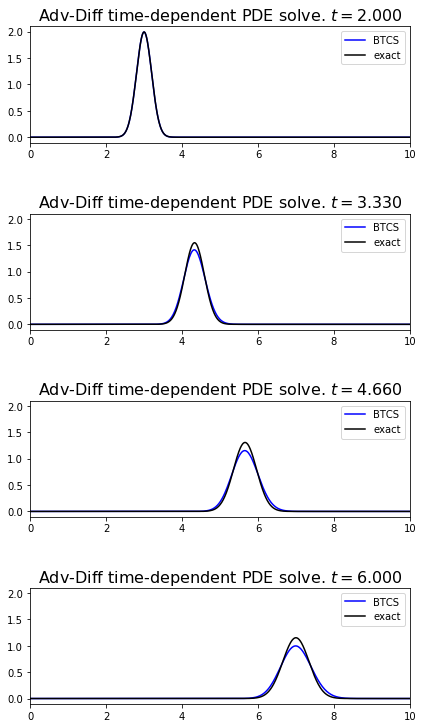

In [22]:
finite_diff_plotter(solve_adv_diff_Gaussian_BE(N, dt, t_start, t_end, U, kappa), 'BTCS', 'b-')

BTCS is unconditionally stable. Like FTCS, the overlap of the exact solution and the numerical solution (BTCS) worsens with increasing time.

In [23]:
def solve_adv_diff_Gaussian_crank(N, dt, t_start, t_end, U, kappa):
    """ Solve the advection-diffusion problem on a periodic domain
    with a hard coded Gaussian-shaped initial condition. Crank Nicolson method.
    
    Returns:
    C - the solution at all time levels.
    x - the spatial mesh.
    t - the time levels.
    """
    # define spatial mesh
    dx = L / N
    x = np.linspace(0, L, N)
       
    # create discretisation matrix
    Dx = adv_central_periodic(N)
    Dxx = diff_central_periodic(N)
    A = -(U / dx) * Dx + (kappa / dx**2) * Dxx

    t = np.arange(t_start, t_end + 1e-14 , dt)

    C = np.empty((len(x), len(t)))
    
    # define an initial condition
    C[:,0] = adv_diff_analytical_solution(U, kappa, x0, x, t_start)
    #Identity matrix is matrix equivalent of adding 1
    I = np.eye(len(x))
    #Numerically solving the PDE at different times and storing in matrix C, using previous columns in calculation of the next column. Crank Nicolson
    for n in range(len(t)-1):
        C[:,n+1] = np.linalg.solve(I - (dt/2)*A, (I + (dt/2)*A) @ C[:,n])
    return C, x, t

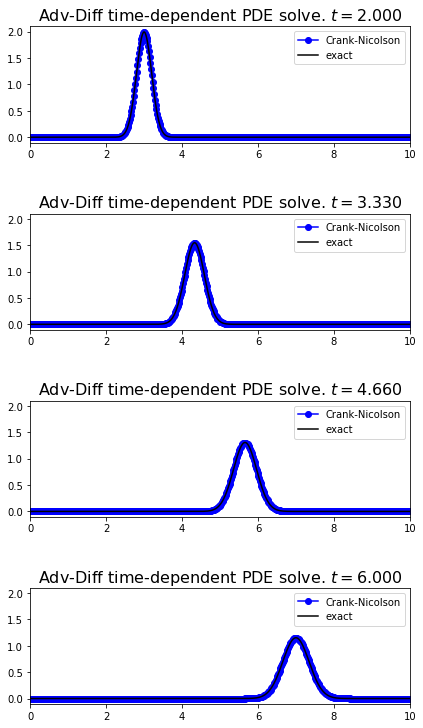

In [24]:
finite_diff_plotter(solve_adv_diff_Gaussian_crank(N, dt, t_start, t_end, U, kappa), 'Crank-Nicolson', 'bo-')

The overlap of the Crank-Nicolson method solution and the exact solution was such that the one could not distinguish between the two from a visual standpoint. Hence i have included a dotted line to represent Crank-Nicolson. Across all the plotted graphs, Crank-Nicolson shows a great overlap and is a superior method compared to FTCS and BTCS.

In [25]:
def solve_adv_diff_Gaussian_theta(N, dt, t_start, t_end, U, kappa, theta):
    """ Solve the advection-diffusion problem on a periodic domain
    with a hard coded Gaussian-shaped initial condition.
    
    Returns:
    C - the solution at all time levels.
    x - the spatial mesh.
    t - the time levels.
    """
    # check input variables are valid
    assert t_start > 0
    assert t_end > 0
    assert dt > 0
    assert N > 0
    theta = float(theta)
    Theta_error = ValueError("You inputted an invalid value for theta. Please input 0., 0.5 or 1. depending on your preferred scheme")
    acceptable_theta = [0., 0.5, 1.]
    if theta not in acceptable_theta:
        raise Theta_error    
    # define spatial mesh
    dx = L / N
    x = np.linspace(0, L, N)
       
    # create discretisation matrix
    Dx = adv_central_periodic(N)
    Dxx = diff_central_periodic(N)
    A = -(U / dx) * Dx + (kappa / dx**2) * Dxx
    
    t = np.arange(t_start, t_end + 1e-14, dt)

    C = np.empty((len(x), len(t)))
    
    # define an initial condition
    C[:,0] = adv_diff_analytical_solution(U, kappa, x0, x, t_start)
    #Identity matrix is matrix equivalent of adding 1
    I = np.eye(len(x))
    # looping over in range of t to calculate the c coordinates at different t with a specified theta value input
    for n in range(len(t)-1):
        C[:,n+1] = np.linalg.solve(I - (dt * theta * A), (I + dt *A *(1 - theta)) @ C[:,n] )
    return C, x, t


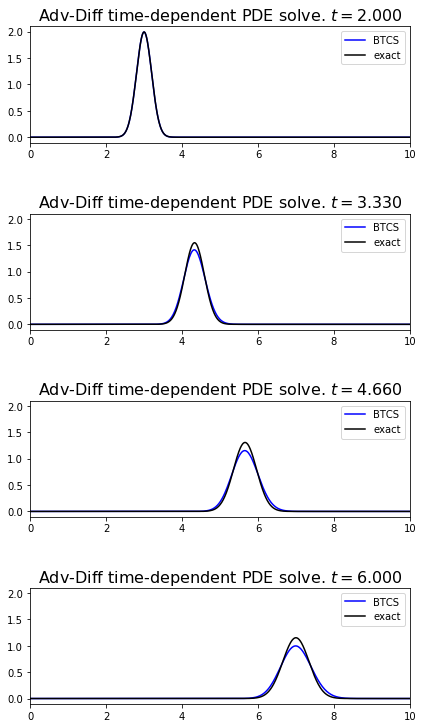

In [26]:
# Choose theta as either 0., 0.5 or 1. below
theta = 1.
if theta == 0.:
    label = 'FTCS'
    line_graphic = 'b-'
elif theta == 0.5:
    label = 'Crank-Nicolson'
    line_graphic = 'o'
else:
    label = "BTCS"
    line_graphic = 'b-'
finite_diff_plotter(solve_adv_diff_Gaussian_theta(N, dt, t_start, t_end, U, kappa, theta), label, line_graphic)


References for theory on question two:
- http://dma.dima.uniroma1.it/users/lsa_adn/MATERIALE/FDheat.pdf
- http://web.cecs.pdx.edu/~gerry/class/ME448/lecture/pdf/FTCS_slides.pdf
- https://www3.nd.edu/~gtryggva/CFD-Course/2013-Lecture-2.pdf
- http://hplgit.github.io/num-methods-for-PDEs/doc/pub/trunc/pdf/trunc-4screen.pdf
- http://events.asiaa.sinica.edu.tw/school/20181018/talk/lecture01-fundamentals.pdf
- http://hplgit.github.io/INF5620/doc/pub/H14/trunc/html/._main_trunc001.html#trunc:fd:forward
- https://scicomp.stackexchange.com/questions/24580/more-smearing-with-decreasing-timestep-in-advection-problems/24588#24588
- http://twister.caps.ou.edu/CFD2007/Chapter3_3.pdf

A solution to the advection & diffusion equation which is apporixmate is convergent if said solution approaches the exact solution of the PDE for each value of the indepedent variables as the mesh spacing tends to zero. Therefore,
\begin{align*}
C^{n}_{i} \rightarrow C(x_{i},t_{n}),\; \text{as}\; \Delta x, \Delta t \rightarrow 0
\end{align*}
The spatial discretisation of the advection & diffusion equation is given by :
\begin{align*}
\frac{\partial c_i}{\partial t} + U\frac{c_{i+1} - c_{i-1}}{2\Delta x}  = \kappa\frac{c_{i+1} - 2c_i + c_{i-1}}{\Delta x^2} + \mathcal{O}({\Delta x^2})
\;\;\;\;\;\;\; \text{or} \;\;\;\;\;\;\;
\frac{\partial c_i}{\partial t} = \kappa\frac{c_{i+1} - 2c_i + c_{i-1}}{\Delta x^2} - U\frac{c_{i+1} - c_{i-1}}{2\Delta x} + \mathcal{O}({\Delta x^2})
\\[10pt]  
\end{align*}

The forward difference is given by:
\begin{align*}
\frac{\partial c_i}{\partial t}\Bigr|_{\substack{t_{n}\\x_{i}}} = \frac{c^{n+1}_{i} - c^{n}_{i}}{\Delta t} + \mathcal{O}({\Delta t})
\end{align*}



The backward difference is given by:
\begin{align*}
\frac{\partial c_i}{\partial t}\Bigr|_{\substack{t_{n}\\x_{i}}} = \frac{c^{n}_{i} - c^{n-1}_{i}}{\Delta t} + \mathcal{O}({\Delta t})
\end{align*}


The central difference is given by:
\begin{align*}
\frac{\partial c_i}{\partial t}\Bigr|_{\substack{t_{n}\\x_{i}}} = \frac{c^{n+\frac{1}{2}}_{i} - c^{n-\frac{1}{2}}_{i}}{\Delta t} + \mathcal{O}({\Delta t^2})
\end{align*}
The truncation error associated with central difference is :
\begin{align*}
\frac{1}{24}c'''(t_{n})\Delta t^2 + \mathcal{O}({\Delta t^4})
\end{align*}
The term $ \mathcal{O}({\Delta t^4}) $ is a very small value if $\Delta t$ is fairly small that in practice the leading order term is ~ $\Delta t^2$.

The spatial local truncation error associated with the discretisation of the  advection & diffusion equation is $\mathcal{O}({\Delta x^3})$. This spatial error is true for all centered in space methods such as FTCS, BTCS and Crank Nicolson where $\mathcal{O}({\Delta x^p})$ and p is equal to 3. This is related to do the cut off point of the taylor series in which the terms that have been effectively set at 0 as the truncation error. The leading term is of an order $\Delta x^2$. With the mesh spacing of x getting increasingly smaller whilst the length and timestep remain the same, the $ \Delta x^2$ term approches zero. If $ \Delta t$ is sufficiently small and the timestep fixed, one can imagine the error relating to $ \Delta t$ as negligible. Therefore, one can calculate for the global error $\mathcal{O}({\Delta x^p})$.

The temporal local truncation error associated with the the discretisation of the  advection & diffusion equation for FTCS and BTCS is $ \mathcal{O}({\Delta t^q})$ where q=2. Similar as for the spatial truncation error, this can be seen by expanding the taylor series around a point. The global error, the leading order term in the taylor expansion series is thus $\Delta t$.

The Crank-Nicolson method is advantageous compared to BTCS and FTCS as it has a temporal truncation error of $ \mathcal{O}({\Delta t^q})$ where q=4. However, the leading order term in the taylor series, given the truncation is $\Delta t^2$. Therefore, the associated truncation errors for BTCS and FTCS are larger than Crank-Nicolson method.

The order of accuracy then for spatial is $\mathcal{O}({\Delta x^2})$ for all methods. For temporal, $\mathcal{O}({\Delta t^2})$ is the order of accuracy for Crank-Nicolson and $\mathcal{O}({\Delta t})$ for FTCS and BTCS.

The cell peclet number of 2 indicates the advection term is larger than the diffusion. Therfore, the error is amplified more so in the advection term than the diffusion term. The error associated with advection is diffusive as seen by :
\begin{align*}
\text{Truncation err} = U\frac{\Delta x}{2}\frac{\partial^2 c}{\partial x^2}(1-CFL)
\end{align*}
The error depends on that of the second derivative in space hence the error is diffusive, thus a smearing effect which can be seen on the plots as we take the values at larger t values. The plot of the numerical solution exhibits a higher diffusivity than the exact solution. This error is termed numerical diffusion. If $\Delta t$ is reduced then the diffusive error term will become larger, hence $\Delta x$ must also be reduced. Again, this increases the cost.

In [27]:
track_err_FTCS = []
track_err_BTCS = []
track_err_crank = []
x_mesh_spacing = []

U = 0.15
kappa = 1./80.
N = 200
L = 10.
dx = L / N
dt = 0.0004
t_start = 2.
t_end = t_start + 4.
x0 = 1.0
#t = np.arange(t_start, t_end, dt)
def RMSE_ERROR(dt, N, U, kappa):
    C, x, t = solve_adv_diff_Gaussian_FE(N, dt, t_start, t_end, U, kappa)
    
    C_exact = adv_diff_analytical_solution(U, kappa, x0, x, t[-1])
    err_FTCS = rmse(C[:,-1], C_exact)
    C, x, t = solve_adv_diff_Gaussian_theta(N, dt, t_start, t_end, U, kappa, theta = 0.5)
    err_BTCS = rmse(C[:,-1], C_exact)
    C, x, t = solve_adv_diff_Gaussian_theta(N, dt, t_start, t_end, U, kappa, theta = 1.0)
    err_crank = rmse(C[:,-1], C_exact)
    return err_FTCS, err_BTCS, err_crank, x

while N > 99:
    dx = L / N
    x_mesh_spacing.append(dx)
    err_FTCS, err_BTCS, err_crank, x = RMSE_ERROR(dt, N, U, kappa)
    track_err_FTCS.append(err_FTCS)
    track_err_BTCS.append(err_BTCS) 
    track_err_crank.append(err_crank)
    N -= 20

Pe_c: 0.60000.  Stable: True
CFL:  0.00120.  Stable: True
r:    0.00200.  Stable: True
Pe_c: 0.66667.  Stable: True
CFL:  0.00108.  Stable: True
r:    0.00162.  Stable: True
Pe_c: 0.75000.  Stable: True
CFL:  0.00096.  Stable: True
r:    0.00128.  Stable: True
Pe_c: 0.85714.  Stable: True
CFL:  0.00084.  Stable: True
r:    0.00098.  Stable: True
Pe_c: 1.00000.  Stable: True
CFL:  0.00072.  Stable: True
r:    0.00072.  Stable: True
Pe_c: 1.20000.  Stable: True
CFL:  0.00060.  Stable: True
r:    0.00050.  Stable: True


The stability conditions for FTCS are met upon each iteration in the value of dx becomings increasingly smaller.

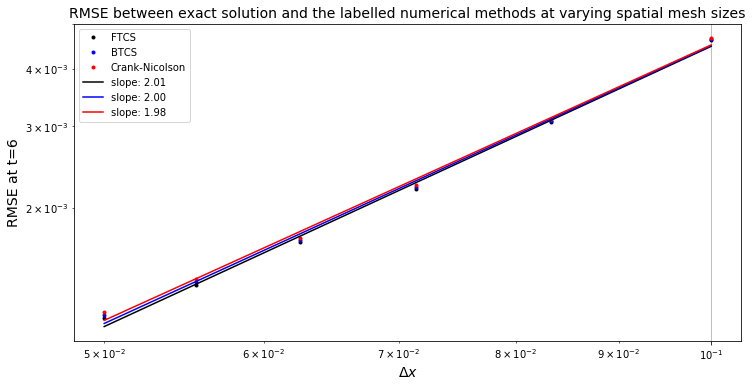

In [28]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
fig.tight_layout(w_pad=4, h_pad=5)
ax1.loglog(x_mesh_spacing, track_err_FTCS, 'k.', label='FTCS')
ax1.loglog(x_mesh_spacing, track_err_BTCS, 'b.', label='BTCS')
ax1.loglog(x_mesh_spacing, track_err_crank, 'r.', label="Crank-Nicolson")
start_fit = 0
ax1.set_xlabel('$\Delta x$', fontsize=14)
ax1.set_ylabel('RMSE at t=6', fontsize=14)
ax1.set_title('RMSE between exact solution and the labelled numerical methods at varying spatial mesh sizes', fontsize=14)
ax1.grid(True)

line_fit_ftcs = np.polyfit(np.log(x_mesh_spacing[start_fit:]), np.log(track_err_FTCS[start_fit:]), 1)
line_fit_btcs = np.polyfit(np.log(x_mesh_spacing[start_fit:]), np.log(track_err_BTCS[start_fit:]), 1)
line_fit_crank = np.polyfit(np.log(x_mesh_spacing[start_fit:]), np.log(track_err_crank[start_fit:]), 1)
ax1.loglog(x_mesh_spacing, np.exp(line_fit_ftcs[1]) * x_mesh_spacing**(line_fit_ftcs[0]), 'k-', label = 'slope: {:.2f}'.format(line_fit_ftcs[0]))
ax1.loglog(x_mesh_spacing, np.exp(line_fit_btcs[1]) * x_mesh_spacing**(line_fit_btcs[0]), 'b-', label = 'slope: {:.2f}'.format(line_fit_btcs[0]))
#
ax1.loglog(x_mesh_spacing, np.exp(line_fit_crank[1]) * x_mesh_spacing**(line_fit_crank[0]), 'r-', label = 'slope: {:.2f}'.format(line_fit_crank[0]))
ax1.legend(loc='best')

By choosing a small $\Delta t$ value, we can isolate the spatial error. As demonstrated earlier, the leading order spatial term for all 3 methods has an order of 2. The temporal leading order term for FTCS and BTCS is 1. Thefore, a smaller $\Delta t$ value would be needed to isolate the spatial error for FTCS and BTCS than Crank-Nicolson which has a leader order term of 2. However, in this case the same $\Delta t$ value was used for simplicity. The graph shows convergence in a linear fashion on a log-log plot with a slope of 2 which agrees with the theoretical result that the truncation error is of second order in $\Delta t$.



To achieve the demonstration of the truncation error, U and kappa) were modified. To achieve stability for FTCS, the reaction conditions are limited and $\Delta t, \Delta x$ must be also limited by the stability inequalities. As a result, this heavily impedes on the values of these parameters when solving a hyperbolic PDE such as the advection-diffusion equation explicity. Changing the physical values of the problem is difficult to achieve, the diffusivity value can sometimes be altered but the speed of advection cannot be justified. Hence, if the physical values must remain the same, when the mesh size is halved, the timestep should also be reduced by a factor of four in order to ensure numerical stability.

The CFL stability inequality limits $\Delta t$ for any given $\Delta x$ and velocity. The advection-diffusion equation has a finite physical domain of dependence. The wave cannot travel a greater distance than $\Delta x$ otherwise it is outside the physical domain of dependence. If it does, and hence the inequality is not satisfied, the solution becomes unstable. If $\Delta x$ is smaller than $U\Delta t$ then the characteristic line no longer lands in the domain of dependence. Therefore as said previously, for FTCS, the conditions are limited.

BTCS is an implicit scheme which is unconditonally stable for any size $\Delta t$. However, when using a larger $\Delta t$, there will be larger truncation errors. In addition, we use an iterative jacobian solver in BTCS, meaning BTCS is more expensive timewise and in storage space than FTCS.

When decreasing $\Delta x$ the cell peclet number increases, therefore, the advection term is getting larger, while the diffusive one smaller. The CFL is marginally decreasing meaning the advection diffusive error is growing larger. Hence at the same $\Delta t$ value, decreasing the value of $\Delta x$ will increase the truncation error $\mathcal{O}({\Delta x^2})$. However, given the small velocity value chosen U = 0.15, the amplification of this error is not great, hence the 3 methods were able to proven using the same parameters as a result of changing the values of U and kappa.

As the truncation spatial error is $\mathcal{O}({\Delta x^2})$ for all three methods they can be plotted on the same graph. Trying to achieve the same for truncation temporal error is not possible. If one is to demonstrate FTCS and BTCS have  a temporal slope of 1 with the same parameters CN-CS will likely have a slope of roughly near 0 given CN-CS converges quicker with a temporal truncation error of $\mathcal{O}({\Delta t^2})$

In [29]:
def RMSE_ERROR_FDM(dt, N, U, kappa, theta):
    """
    Returns rmse error for FDM at different theta values
     and the exact solution at the final timestep t =6 
    """
    C, x, t = solve_adv_diff_Gaussian_theta(N, dt, t_start, t_end, U, kappa, theta)
    C_exact = adv_diff_analytical_solution(U, kappa, x0, x, t[-1])
    err = rmse(C[:,-1], C_exact)
    return err

In [30]:
track_err_FTCS = []
track_err_BTCS = []
track_err_crank = []
dt_mesh_spacing = []

U = 1.
kappa = 1./100.
N = 800
L = 10.
dx = L / N
dt = 0.005
t_start = 2.
t_end = t_start + 4.
x0 = 1.0
while dt > 0.001:
    dx = L / N
    dt_mesh_spacing.append(dt)
    err_FTCS = RMSE_ERROR_FDM(dt, N, U, kappa, theta = 0.)
    track_err_FTCS.append(err_FTCS)
    dt *= 0.75

The stability conditions are met on each loop with different $\Delta t$ values.

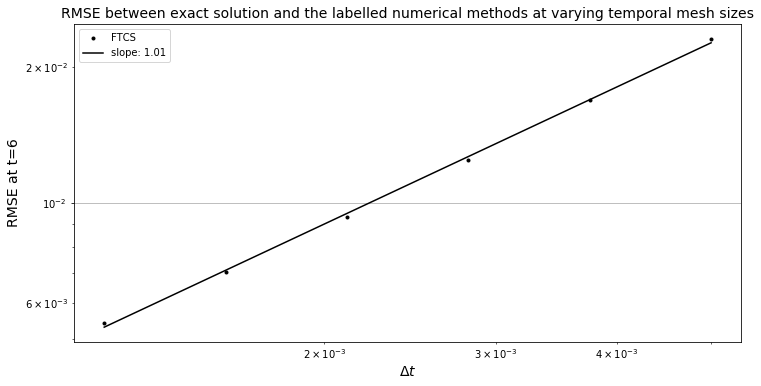

In [31]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))

fig.tight_layout(w_pad=4, h_pad=5)
ax1.loglog(dt_mesh_spacing, track_err_FTCS, 'k.', label='FTCS')

start_fit = 0

ax1.set_xlabel('$\Delta t$', fontsize=14)
ax1.set_ylabel('RMSE at t=6', fontsize=14)
ax1.set_title('RMSE between exact solution and the labelled numerical methods at varying temporal mesh sizes', fontsize=14)
ax1.grid(True)

line_fit_ftcs = np.polyfit(np.log(dt_mesh_spacing[start_fit:]), np.log(track_err_FTCS[start_fit:]), 1)
ax1.loglog(dt_mesh_spacing, np.exp(line_fit_ftcs[1]) * dt_mesh_spacing**(line_fit_ftcs[0]), 'k-', label = 'slope: {:.2f}'.format(line_fit_ftcs[0]))
ax1.legend(loc='best')

FTCS is conditionally stable and hence the stability parameters needed to be met to prove the convergence and that the power of $\Delta t$ is 1. A relatively small $\Delta x$ was used. The error for the spatial is quadratic and so a very small $\Delta x$ is not required as the the term is squared which is itself is a very small contribution to the truncation error. The change in $\Delta t$ was limited to ensure stability remained. In addition, given velocity of U = 1, $\Delta t$ must be  at least double the size of $\Delta x$. The cell peclet number does not change as a result of $\Delta t$ changing, the advection and diffusion maintain the same level of dominance.

In [32]:
track_err_FTCS = []
track_err_BTCS = []
track_err_crank = []
dt_mesh_spacing = []
U = 1.
kappa = 1./100.
N = 2000
L = 10.
dx = L / N
dt = 0.01
t_start = 2.
t_end = t_start + 4.
x0 = 1.0
while dt > 0.001:
    dx = L / N
    dt_mesh_spacing.append(dt)
    err_BTCS = RMSE_ERROR_FDM(dt, N, U, kappa, theta = 1.)
    track_err_BTCS.append(err_BTCS) 
    dt *= 0.5
assert len(track_err_BTCS) == len(dt_mesh_spacing)


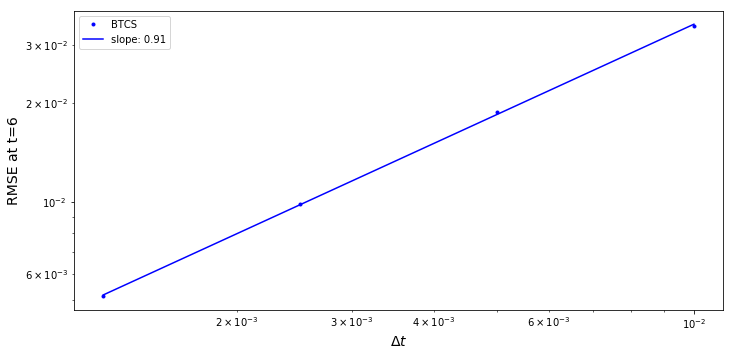

In [33]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax1.set_xlabel('$\Delta t$', fontsize=14)
ax1.set_ylabel('RMSE at t=6', fontsize=14)
fig.tight_layout(w_pad=4, h_pad=5)
ax1.loglog(dt_mesh_spacing, track_err_BTCS, 'b.', label='BTCS')
start_fit = 0
line_fit_btcs = np.polyfit(np.log(dt_mesh_spacing[start_fit:]), np.log(track_err_BTCS[start_fit:]), 1)
ax1.loglog(dt_mesh_spacing, np.exp(line_fit_btcs[1]) * dt_mesh_spacing**(line_fit_btcs[0]), 'b-', label = 'slope: {:.2f}'.format(line_fit_btcs[0]))
ax1.legend(loc='best')

The expected slope value is 1 which should match the theoretical truncation error $\Delta t^q$ where q = 1. When using the exact same parameters for BTCS as FTCS the slope was 0.88. Increasing N to 2000, the value of $\Delta x$ decreased. However, even with such a large increase of N the value of the slope only marginally gets closer to the expected result of 1. This could potentially be due to that BTCS has an odd-order derivative in the leading term whilst FTCS has an even-order derivative in the leading term for the advection component. An odd order leads to a dispersion error where the waves propagate at different speeds as a result of numerical approximation. While an even order leads to dissipation error leading to a loss of wave amplitude. It could also potentially be due to BTCS being solved implictly with an iterative solver which itself is only an approximation.

In [34]:
track_err_FTCS = []
track_err_BTCS = []
track_err_crank = []
dt_mesh_spacing = []
U = 1.
kappa = 1./100.
N = 2000
L = 10.
dx = L / N
dt = 0.25
t_start = 2.
t_end = t_start + 4.
x0 = 1.0
while dt > 0.01:
    dx = L / N
    dt_mesh_spacing.append(dt)
    err_crank = RMSE_ERROR_FDM(dt, N, U, kappa, 0.5)
    track_err_crank.append(err_crank)
    dt *= 0.5
    

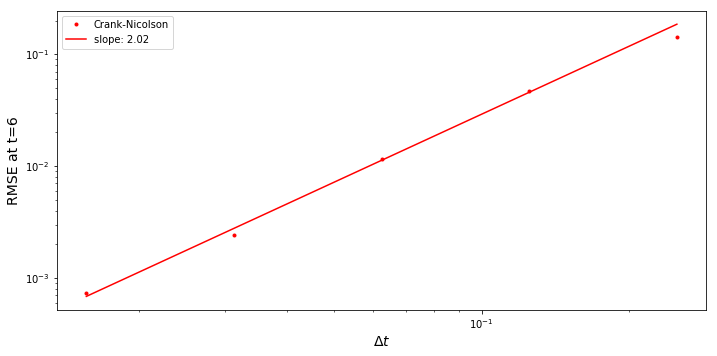

In [35]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
#axs = axs.reshape(-1)
ax1.set_xlabel('$\Delta t$', fontsize=14)
ax1.set_ylabel('RMSE at t=6', fontsize=14)
fig.tight_layout(w_pad=4, h_pad=5)
start_fit = 1
ax1.loglog(dt_mesh_spacing, track_err_crank, 'r.', label="Crank-Nicolson")
line_fit_crank = np.polyfit(np.log(dt_mesh_spacing[start_fit:]), np.log(track_err_crank[start_fit:]), 1)
ax1.loglog(dt_mesh_spacing, np.exp(line_fit_crank[1]) * dt_mesh_spacing**(line_fit_crank[0]), 'r-', label = 'slope: {:.2f}'.format(line_fit_crank[0]))
ax1.legend(loc='best')

The starting and end value of $\Delta t$ are vastly different for proving Crank-Nicolson scheme compared to FTCS and BTCS. This is due to the temporal truncation error being  $\mathcal{O}({\Delta t^2})$. Too small a value of $\Delta t$ and the asymptote limit would have already been reached resulting in a slope of 0. Hence, a large enough starting dt value was required to accurately represent the order of error.

CONCLUSION FOR QUESTION 2

- FTCS is limited by choice of $\Delta x$ and $\Delta t$ due to the stability inequalities (Cell peclet number, CFL condition, r parameter). In addition, it is also limited by choice of kappa and velocity. A high velocity means the speed of which the error propagates is greatly increased. Similarly, a small value of kappa reduces the error that propagates through diffusion.

- The choice of parameters must be within the stability region and the region the eigenvalues form otherwise undershoots/overshoots can occur. This is seen on the graph 'Eigenvalues vs stability region'.

- BTCS is unconditonally stable as it is implicit. However, more computation is required at each step as a numerical solver is used to calculate the new c(x) values at $t_{n}$

- Crank-Nicolson is also stable and implicit. Similar to BTCS, more computation is required and in fact more so than BTCS as the matrix system needed to be solved to obtain c(x) at the the next time step is more demanding.

- The error in the advection term propagates via diffusion.

- All three methods converge when $\Delta t$ and $\Delta x$ are made smaller. However, $\Delta x$ should be reduced by a factor of 4 in comparision to a reduction in $\Delta t$ such that the stability inequalities are satisfied.

- Crank-Nicolson is the best scheme overall due to have a temporal order of 1 greater than that of FTCS and BTCS. A larger $\Delta t$ value can be used when applying the Crank-Nicolson scheme compared to using FTCS or BTCS because of it having a larger temporal truncation order.

- In any methods in which the inversion of a matrix was required to solve for C[:,n], a jacobian iterative solver was used which dramtically reduces the time taking the solve the matrix system.

QUESTION 3

References for question 3
- Galerkin-finite_element_method_for_the_numerical_s.pdf
- https://people.maths.ox.ac.uk/suli/fem.pdf
- https://www-m16.ma.tum.de/foswiki/pub/M16/Allgemeines/NumMethHyp14/FE-Hyperbolic-Systems.pdf
- https://cpb-us-e1.wpmucdn.com/blogs.gwu.edu/dist/9/297/files/2018/01/66bdd115ac105ea17af303e73d4fec449754-v448bk.pdf
- http://hplgit.github.io/INF5620/doc/pub/sphinx-fem/._main_fem003.html
- https://warwick.ac.uk/fac/sci/hetsys/studentinformation/induction/mathsinduction/pde/pde.pdf
- https://people.maths.ox.ac.uk/suli/fem.pdf
- https://en.m.wikipedia.org/wiki/Crank-Nicolson_method

General of FEM is to approximates te numerical solution (function) and solves the weak form of the differential equation. The weak form is not requried to hold absolutely and has a weak solution with respect to certain test functions. To minimise the interpolant error, one can peform the calculation where the inner product of the residual is orthogonal to individual basis functions. The weight of said basis function is the matrix entry of the mass matrix M. A domain $\Omega$ is split into sub domains $\Omega ^{0}\: \cup ... \cup \:\Omega ^{N_{e}}$. An element can be refered to as $\Omega ^{(e)}$. Each element contains nodes and in our case are evenly spaced. Nodes are given a number within an element (local) and in the domain $\Omega$ (global).

In [36]:
def generate_1D_CG_mesh(Lx, N_elements_CG, mesh_option=0):
    """ Function to generate a mesh given the domain size Lx
    (we assume the left hand entry is always at zero).
    
    Use N_elements_CG number of element.
    
    mesh_option==0 corresponds to a uniform mesh - only option implemented so far.
    
    Returns: the node locations x_node and the mesh spacing dx
    """
    if(mesh_option==0):
        x_nodes = np.linspace(0, Lx ,N_elements_CG + 1)
    else:
        raise Exception('mesh_option != 0 not implemented yet')
    # given the mesh compute an array of element sizes
    dx = np.diff(x_nodes)
    return x_nodes, dx # x_nodes similar to mesh spacing in finite difference

The function generate_1D_CG_mesh returns x_nodes which are the position of the global nodes and dx, the difference between each node which in this case is the same. It is therefore said to be a uniformly partionited mesh.

In [37]:
def connectivity(N_loc, N_elements_CG):
    """ Generate the connectivity matrix of dimension N_loc * N_elements_CG.
    
    Row corresponds to the local node number, column to the element number,
    the entry of the matrix is then a global node number.
    
    Returns: the connectivity matrix
    """
    connectivity_matrix = np.zeros((N_loc, N_elements_CG), dtype=int)
    if(N_loc==2):
        for element in range (N_elements_CG):
            connectivity_matrix[0, element] = element
            connectivity_matrix[1, element] = element + 1
    else:
        raise Exception('Only linear element (N_loc=2) implemented.')
    return connectivity_matrix

The connectivity matrix allows us to access the global node number when knowing the local node and element number.

In [38]:
def shape(N_loc, N_gi):
    """ Define reference shape functions - 
    their values at N_gi quadrature points.
    
    Only implemented for N_loc = 2, i.e. 
    two nodes per element - linear basis functions.
    """ 
    assert(N_loc==2)
    phi = np.zeros( (N_loc, N_gi) )
    if(N_gi==2):
        phi[0,0] = 1.0 
        phi[0,1] = 0.0 
        phi[1,0] = 0.0 
        phi[1,1] = 1.0
    elif(N_gi==3):
        phi[0,0] = 1.0 
        phi[0,1] = 0.5 
        phi[0,2] = 0.0 
        phi[1,0] = 0.0 
        phi[1,1] = 0.5 
        phi[1,2] = 1.0        
    else:
        raise Exception('N_gi value not implemented.')
    return phi

def shape_derivatives(element, dx, N_loc, N_gi):
    """ Define derivatives of shape functions - their values at N_gi quadrature points
    over the reference element.
    
    Only implemented for N_loc = 2, i.e. two nodes per element - 
    linear basis functions.
    """   
    assert(N_loc==2)
    phi_x = np.zeros( (N_loc, N_gi) )
    # the derivatives of our linear basis functions over the reference element
    if(N_gi==2):
        phi_x[0,0] = -1. / 2. 
        phi_x[0,1] =  phi_x[0,0] 
        phi_x[1,0] = -phi_x[0,0]  
        phi_x[1,1] =  phi_x[1,0]
    elif(N_gi==3):
        phi_x[0,0] = -1. / 2. 
        phi_x[0,1] = phi_x[0,0] 
        phi_x[0,2] = phi_x[0,0] 
        phi_x[1,0] = -phi_x[0,0] 
        phi_x[1,1] = phi_x[1,0] 
        phi_x[1,2] = phi_x[1,0]            
    else:
        raise Exception('N_gi value not implemented.')
    # Jacobian contribution as seen/explained above due to the use of the chain rule
    phi_x = phi_x * (2. / dx[element]) 
    return phi_x

A basis function $\phi_{i}(x_{j})$ has the properties $\delta_{ij} =
    \begin{cases}
            1, &         \text{if } i=j,\\
            0, &         \text{if } i\neq j.
    \end{cases}$ 

A piecewise linear approximation can be implemented to approximate our function in the form:
\begin{align*}
f_{h}(x) = \sum_i^N \alpha_{i}\phi_{i}(x)
\end{align*}

The basis function takes the form of a lagrange polynomial. A basis function refers to specific global nodes and is 0 in most places. As in, the basis function $\psi_{i}(x)$ is zero on any element which does not contain the node which corresponds to the global node number i. Hence in the shape function if $i = j$ the value is 1.0 and if $i \neq j $ then the value is 0. It is the evaluation of the basis function at chosen x.

As these are linear piecewise with a peak of 1 the derivatives are clearly $ \pm \frac{1}{2}$ which can be seen in the shape_derivative function.

In [39]:
def quadrature(N_gi):
    """ Define quadrature rule on N_gi quadrature points.
    """    
    weight = np.zeros(N_gi)
    if(N_gi==2):  # Trapezoidal rule in 1D
        weight[0] = 0.5 
        weight[1] = 0.5
    elif(N_gi==3): # Simpson's rule in 1D
        weight[0] = 1. / 6. 
        weight[1] = 2. / 3. 
        weight[2] = 1. / 6.
    else:
        raise Exception('N_gi value not implemented.')
    return weight

The corresponding theoretically determined weights used to calculate the integrand either using simpson's rule of trapezoidal rule.

In [40]:
def assembly_local(M, K, K_adv, element, connectivity_matrix, N_loc, N_gi, weight, phi, phi_x, dx):
    """ Perform local assembly by performing a double loop over the local node numbers 
    (in order to form products of local basis functions), 
    computing the required integrals, and adding contributions to the correct 
    locations of the global discretisation matrices.
    As we are solving the Diffusion problem we know we need the mass matrix M, and the 
    diffusion discretisation matrix K.  
    The current versions of the full M and K matrices are passed into this function
    and the local contribitions added in to them, so we don't need to return anything. 
    Alternatively we could return the local contributions and add them in in the 
    calling function.
    """
    for i_loc in range(N_loc):
        i_global = connectivity_matrix[i_loc, element]
        for j_loc in range(N_loc):
            j_global = connectivity_matrix[j_loc, element]
            # perform the quadrature - over one element with one "quadrature interval"
            # "weight" is the quadrature weight, e.g. 1/6, 4/6, 1/6 for Simpson's rule
            # and we need to remember to include the Jacobian determinant
            phi_phi = 0.
            phix_phix = 0.
            phi_phix = 0.
            for gi in range(N_gi):
                phi_phi += weight[gi] * phi[i_loc, gi] * phi[j_loc, gi] * 0.5*dx[element] 
                # dx/2 in the line above is the Jacobian determinant 
                phix_phix += weight[gi] * phi_x[i_loc, gi] * phi_x[j_loc, gi] * 0.5*dx[element] 
                phi_phix += weight[gi] * phi[i_loc, gi] * phi_x[j_loc, gi] * 0.5*dx[element] # Calculate the integral essentially 1/6 * f(a) + 2/3 *f(b) + 1/6 * f(c) which overall is the contribution to a matrix entry.
            M[i_global, j_global] = M[i_global, j_global] + phi_phi 
            K[i_global, j_global] = K[i_global, j_global] + phix_phix
            K_adv[i_global, j_global] = K_adv[i_global, j_global] + phi_phix # update the advection matrix entry with the contribution previously calculated.

           

phi_phi is the result of performing quadrature over one element and i_global, j_global refers to the entry of the mass matrix.

phix_phix is the result of peforming quadrature over one element and i_global, j_global refers to the entry of the diffusion matrix.

phi_phix is the result of peforming quadrature over one element and i_global, j_global refers to the entry of the advection matrix.

In [41]:
def assembly_global(M, K, K_adv, N_elements_CG, connectivity_matrix, N_loc, N_gi, weight, phi, dx):
    """ Perform global assembly by looping over elements.
    """
    # loop over all elements
    for element in range(N_elements_CG):
        # compute the derivatives of the basis function on this element
        phi_x = shape_derivatives(element, dx, N_loc, N_gi)
        # perform local assembly and update the M and K matrices
        assembly_local(M, K, K_adv, element, connectivity_matrix, N_loc, N_gi, weight, phi, phi_x, dx)

In [42]:
def apply_bcs(A, b, lbc, rbc, bc_option=0):
    """Apply BCs using a big spring method.
    
    bc_option==0 Homogeneous Neumann
    bc_option==1 inhomogeneous Dirichlet
    """
    if(bc_option==0):
        # for homogeneous Neumann conditions, for this problem, we have to **do nothing**!
        return
    elif(bc_option==1):
        big_spring = 1.0e10
        A[0,0] = big_spring            
        b[0]   = big_spring * lbc
        A[-1,-1] = big_spring            
        b[-1]   = big_spring * rbc         
    else:
        raise Exception('bc option not implemented')

Boundaries conditions applied at opposite ends of the cell.

In [43]:
def initial_condition(x, IC_option=0):
    """ Function to define an initial condition on our mesh.
    """
    if(IC_option==0):
        return 1.0 * np.exp( -(x - 0.5)**2 / 0.005)
    else:
        raise Exception('Option not implemented.')        

In [44]:
Lx = 10. # Cell width
# Reaction conditions
kappa = 1./100.
U = 1. 
#numerical parameters
N_loc = 2 # number of local nodes per element
N_gi = 3 # quadrature points
# time stepping
dt = 0.01
t = 2.
t_end = t + 4.
# number of global nodes
N_nodes_CG = 501
def FEM(theta, Lx, kappa, U, N_loc, N_gi, t, dt, t_end, N_nodes_CG, bc_option):

    dt_mesh=[] # mesh data
    N_elements_CG = N_nodes_CG - 1 # number of elements 

# generate mesh
    x_nodes, dx = generate_1D_CG_mesh(Lx, N_elements_CG)
    connectivity_matrix = connectivity(N_loc, N_elements_CG)

    u_ic = adv_diff_analytical_solution(U, kappa, x0, x_nodes, t)

# eye on the size of the "r parameter" due to explicit nature when using theta = 0
    print('r parameter: ', kappa*dt/(np.min(dx)**2))
    


# set-up things we need for our discretisation
# the basis functions defined on our reference element
    phi = shape(N_loc, N_gi)

# quadrature weights
    weight = quadrature(N_gi)

# allocate space to store our discretisation matrices
    M = np.zeros((N_nodes_CG, N_nodes_CG))
    K = np.zeros((N_nodes_CG, N_nodes_CG))
    K_adv = np.zeros((N_nodes_CG, N_nodes_CG))
# assemble the individual discretisation matrices
    assembly_global(M, K, K_adv, N_elements_CG, connectivity_matrix, N_loc, N_gi, weight, phi, dx)

    K = kappa * K + K_adv * U # Adding the advection and diffusion matrices which are multiplied by their respective reaction conditions.
#print(K_adv)
    A = M + dt*theta*(K) 
    RHS_matrix = M - dt*(1-theta)*(K) 
#print(K)
# and finally time step
    u_old = np.copy(u_ic)
    while t < t_end + 1e-14: # adding small number due to round off errors.
        b = RHS_matrix @ u_old.T 
        apply_bcs(A, b, 0, 0, bc_option)
        u = sl.solve(A, b)
        u_old = np.copy(u) # using copy saves storage space. We only store the previous calculation required for the next step.
        dt_mesh.append(t)
        t += dt   
    return u, u_ic, x_nodes, dt_mesh

r parameter:  0.25000000000001066
r parameter:  0.25000000000001066
r parameter:  0.25000000000001066
r parameter:  0.1500000000000064


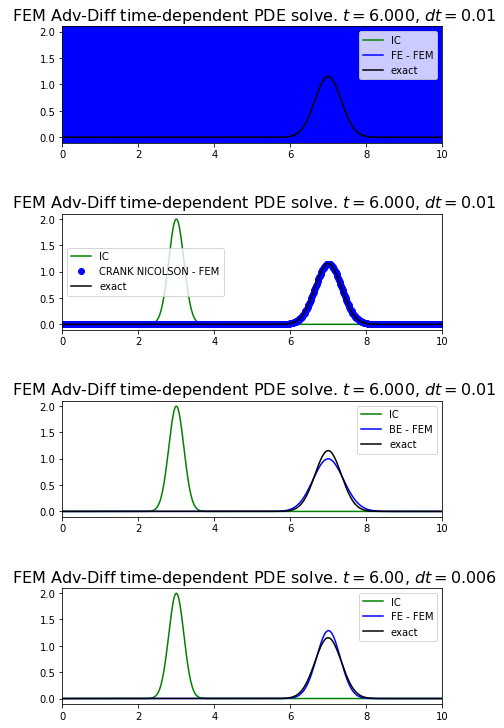

In [45]:
fig, (axs) = plt.subplots(4, 1, figsize=(6, 10))
fig.tight_layout(w_pad=4, h_pad=5)
theta = [0., 0.5, 1., 0.] # acceptable theta values
method = ['FE - FEM', 'CRANK NICOLSON - FEM', 'BE - FEM', 'FE - FEM']
line_graphic = ['b-', 'bo', 'b-', 'b-']
for i in range(4):
    if i == 3 :
        dt = 0.006
    u, u_ic, x_nodes, dt_mesh =  FEM(theta[i], Lx, kappa, U, N_loc, N_gi, t, dt, t_end, N_nodes_CG, bc_option=0)
    axs[i].plot(x_nodes, u_ic, 'g-', label='IC')
    axs[i].plot(x_nodes, u, line_graphic[i], label=method[i])
    axs[i].plot(x_nodes, adv_diff_analytical_solution(U, kappa, x0, x_nodes, t_end), 'k-', label='exact')
    axs[i].legend(loc='best')
    axs[i].set_xlim(0.0, 10.0)
    axs[i].set_ylim(-0.1, 2.1)
    if i != 3:
        axs[i].set_title(' FEM Adv-Diff time-dependent PDE solve. $t=${0:.3f}, $dt=${1:.2f}'.format(dt_mesh[-1], dt), fontsize=16)
    else:
        axs[i].set_title(' FEM Adv-Diff time-dependent PDE solve. $t=${0:.2f}, $dt=${1:.3f}'.format(dt_mesh[-1], dt), fontsize=16)
    

    


Using the same conditions as in Q2 when using FDM ( dt = 0.01, dx = 0.02, L = 10, N = 500), FE-FEM is unstable which is shown by the the plot fully covered in the shade blue which corresponds to the plot of FE-FEM. Crank-Nicolson-FEM from a visual standpoint seems to overlap well while BE-FEM, again from a visual standpoint, shows to be similar to the FDM BTCS. It is likely the instability for FTCS arises from FEM is more exigent on the quality of the mesh approximation. The pelect number is 2 with the given conditions which is equal to the instability bound, thus the mesh could be further refined or a change in $\delta t$ or both. This would also impact the integrands for the mass matrix (M), the diffusion and advection matrix (K). When decreasing $\Delta t$ and thus reducing the value of the r parameter, FE-FEM is stable. The fourth plot uses dt = 0.006, the peak of the guassian curve is higher than that of the exact, the same occurs for FTCS and is expected.

In [46]:
def rms_fem(dt, N_gi, N_nodes_CG, theta, bc_option = 0):
    """
    Function to return rmse between FEM at different
    theta values and the exact function at final timestep
    t = 6
    """
    u, u_ic, x_nodes, dt_mesh = FEM(theta, Lx, kappa, U, N_loc, N_gi, t, dt, t_end, N_nodes_CG, bc_option)
    C_exact = adv_diff_analytical_solution(U, kappa, x0, x_nodes, dt_mesh[-1])
    return C_exact, u, x_nodes
    
    

r parameter:  0.0005760000000000165
r parameter:  0.0004840000000000104
r parameter:  0.0004000000000000029
r parameter:  0.00032400000000000235
r parameter:  0.00025600000000000004
r parameter:  0.0001960000000000014
r parameter:  0.00014400000000000103
r parameter:  0.00010000000000000072


Text(0.5, 1.0, ' Unsteady Adv-Diff approximation using Neumann boundary conditions at t=3 with varying $\\Delta x$, theta = 1')

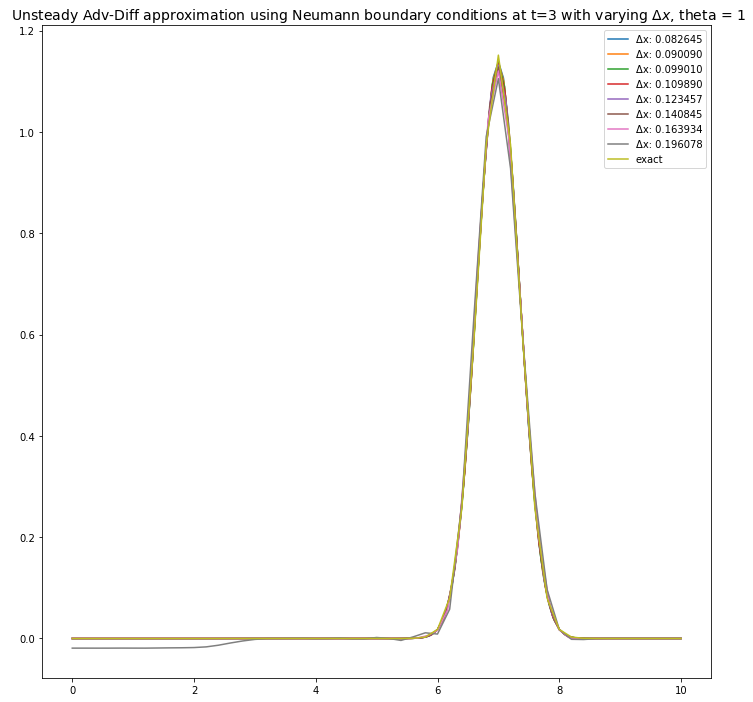

In [47]:
N_nodes_CG = 121
Lx = 10. # Cell width
# Reaction conditions
kappa = 1./100.
U = 1. 
#numerical parameters
N_loc = 2 # number of local nodes per element
N_gi = 3 # quadrature points
# time stepping
#dt = 0.0004
dt = 0.0004
t = 2.
t_end = t + 4.
track_err_FTCS = []
track_err_BE_FEM = []
track_err_crank = []
x_mesh= []
fig, ax1 = plt.subplots(1, 1, figsize=(12, 12))
while N_nodes_CG > 41:
    x_mesh.append(Lx/N_nodes_CG)
    C_exact, u, x_nodes = rms_fem(dt,N_gi, N_nodes_CG, 1., bc_option=0)
    err = rmse(C_exact, u)
    track_err_BE_FEM.append(err)
    ax1.plot(x_nodes, u, label='Δx: {:.6f}'.format(Lx/N_nodes_CG))
    N_nodes_CG -= 10 
ax1.plot(x_nodes, C_exact, label='exact')    
ax1.legend(loc ='best')
ax1.set_title(' Unsteady Adv-Diff approximation using Neumann boundary conditions at t=3 with varying $\Delta x$, theta = 1', fontsize=14)

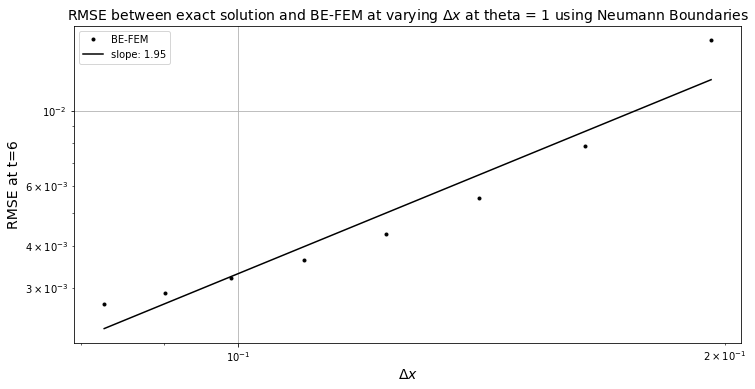

In [48]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))

fig.tight_layout(w_pad=4, h_pad=5)
ax1.loglog(x_mesh,  track_err_BE_FEM, 'k.', label='BE-FEM')

start_fit = 0

ax1.set_xlabel('$\Delta x$', fontsize=14)
ax1.set_ylabel('RMSE at t=6', fontsize=14)
ax1.set_title('RMSE between exact solution and BE-FEM at varying $\Delta x$ at theta = 1 using Neumann Boundaries', fontsize=14)
ax1.grid(True)

line_fit_be_fem = np.polyfit(np.log(x_mesh[start_fit:]), np.log(track_err_BE_FEM[start_fit:]), 1)

ax1.loglog(x_mesh, np.exp(line_fit_be_fem[1]) * x_mesh**(line_fit_be_fem[0]), 'k-', label = 'slope: {:.2f}'.format(line_fit_be_fem[0]))
ax1.legend(loc='best')

r parameter:  0.0005760000000000165
r parameter:  0.0004840000000000104
r parameter:  0.0004000000000000029
r parameter:  0.00032400000000000235
r parameter:  0.00025600000000000004
r parameter:  0.0001960000000000014
r parameter:  0.00014400000000000103
r parameter:  0.00010000000000000072


Text(0.5, 1.0, 'Unsteady Adv-Diff approximation using Dirchlet boundary conditions at t=3 with varying $\\Delta x$ at theta = 1')

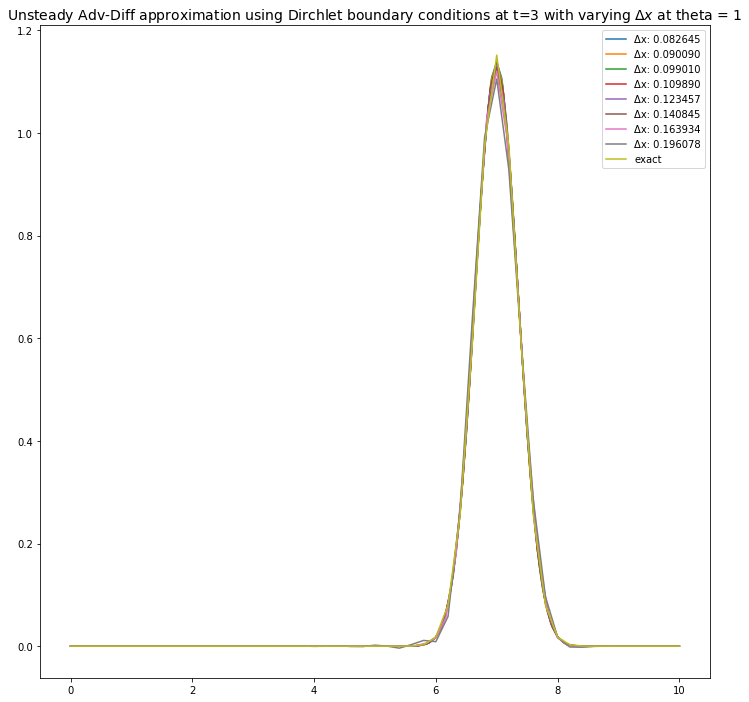

In [49]:

N_nodes_CG = 121
Lx = 10. # Cell width
# Reaction conditions
kappa = 1./100.
U = 1. 
#numerical parameters
N_loc = 2 # number of local nodes per element
N_gi = 3 # quadrature points
# time stepping
dt = 0.0004
t = 2.
t_end = t + 4.
track_err_FTCS = []
track_err_BE_FEM = []
track_err_crank = []
x_mesh= []
fig, ax1 = plt.subplots(1, 1, figsize=(12, 12))
while N_nodes_CG > 41:#31
    x_mesh.append(Lx/N_nodes_CG)
    C_exact, u, x_nodes = rms_fem(dt,N_gi, N_nodes_CG, 1., bc_option = 1)
    err = rmse(C_exact, u)
    track_err_BE_FEM.append(err)
    ax1.plot(x_nodes, u, label='Δx: {:.6f}'.format(Lx/N_nodes_CG))
    N_nodes_CG -= 10 
ax1.plot(x_nodes, C_exact, label='exact')    
ax1.legend(loc='best')
ax1.set_title('Unsteady Adv-Diff approximation using Dirchlet boundary conditions at t=3 with varying $\Delta x$ at theta = 1', fontsize=14)

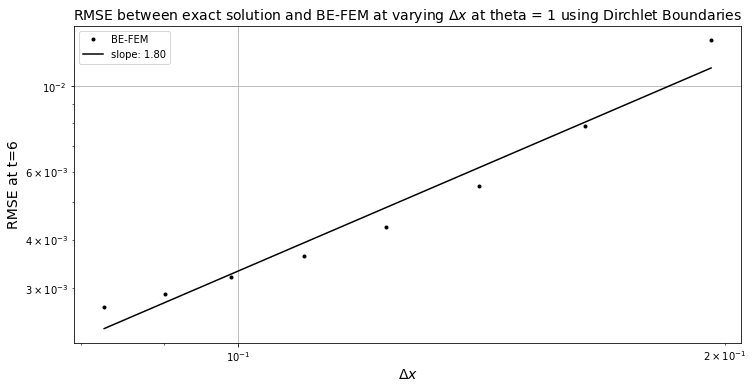

In [50]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))

fig.tight_layout(w_pad=4, h_pad=5)
ax1.loglog(x_mesh,  track_err_BE_FEM, 'k.', label='BE-FEM')

#start_fit = 9
start_fit = 0

ax1.set_xlabel('$\Delta x$', fontsize=14)
ax1.set_ylabel('RMSE at t=6', fontsize=14)
ax1.set_title('RMSE between exact solution and BE-FEM at varying $\Delta x$ at theta = 1 using Dirchlet Boundaries', fontsize=14)
ax1.grid(True)

line_fit_be_fem = np.polyfit(np.log(x_mesh[start_fit:]), np.log(track_err_BE_FEM[start_fit:]), 1)

ax1.loglog(x_mesh, np.exp(line_fit_be_fem[1]) * x_mesh**(line_fit_be_fem[0]), 'k-', label = 'slope: {:.2f}'.format(line_fit_be_fem[0]))
ax1.legend(loc='best')

The rmse converges to the asymptote at a larger $\Delta x$ value for BE-FEM than BTCS. The slope can be seen to have a value of 4.18, which is much greater than that of 2 for BTCS. Therefore, the minimum error can be reached using FEM at larger $\Delta x$ than FDM.

r parameter:  0.0005760000000000165
r parameter:  0.0004840000000000104
r parameter:  0.0004000000000000029
r parameter:  0.00032400000000000235
r parameter:  0.00025600000000000004
r parameter:  0.0001960000000000014
r parameter:  0.00014400000000000103
r parameter:  0.00010000000000000072


Text(0.5, 1.0, ' Unsteady Adv-Diff approximation using Neumann boundary conditions at t=3 with varying $\\Delta x$ at theta = 0')

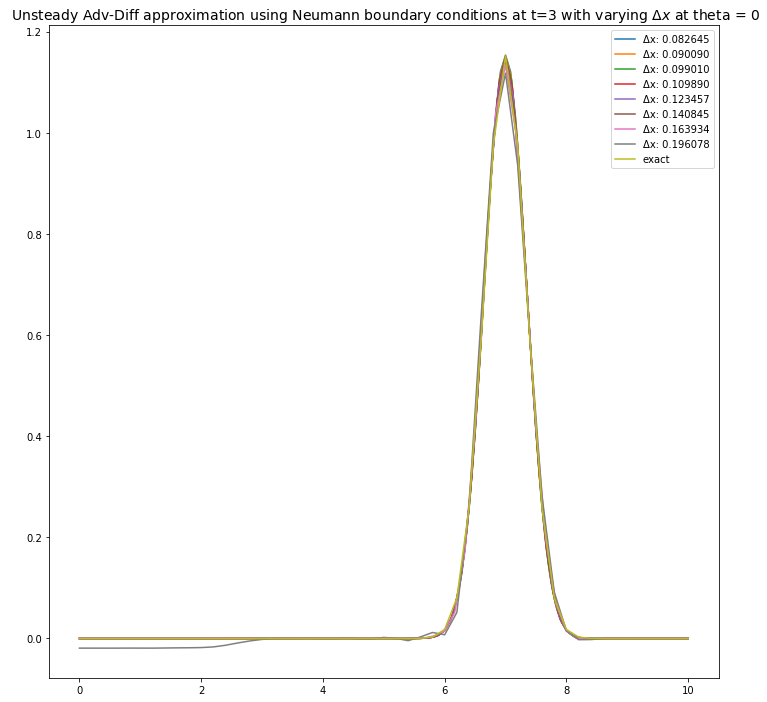

In [51]:

N_nodes_CG = 121
Lx = 10. # Cell width
# Reaction conditions
kappa = 1./100.
U = 1. 
#numerical parameters
N_loc = 2 # number of local nodes per element
N_gi = 3 # quadrature points
# time stepping
dt = 0.0004
t = 2.
t_end = t + 4.

track_err_FE_FEM = []
x_mesh= []
fig, ax1 = plt.subplots(1, 1, figsize=(12, 12))
while N_nodes_CG > 41: # 1
    x_mesh.append(Lx/N_nodes_CG)
    C_exact, u, x_nodes = rms_fem(dt,N_gi, N_nodes_CG, 0., bc_option = 0)
    err = rmse(C_exact, u)
    track_err_FE_FEM.append(err)
    ax1.plot(x_nodes, u, label='Δx: {:.6f}'.format(Lx/N_nodes_CG))
    N_nodes_CG -= 10# 25
ax1.plot(x_nodes, C_exact, label='exact')    
ax1.legend(loc ='best')
ax1.set_title(' Unsteady Adv-Diff approximation using Neumann boundary conditions at t=3 with varying $\Delta x$ at theta = 0', fontsize=14)

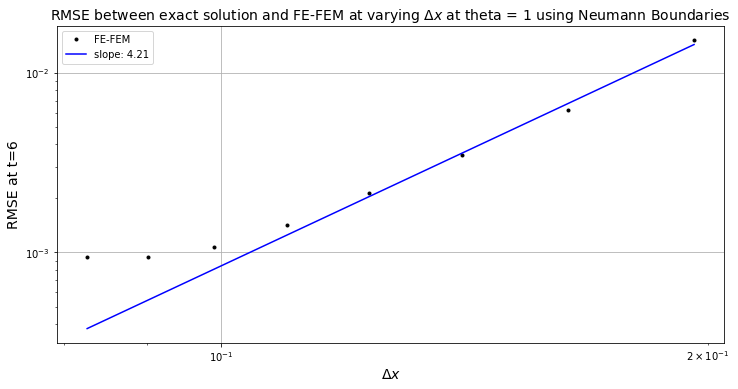

In [52]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))

fig.tight_layout(w_pad=4, h_pad=5)
ax1.loglog(x_mesh,  track_err_FE_FEM, 'k.', label='FE-FEM')

start_fit = 4

ax1.set_xlabel('$\Delta x$', fontsize=14)
ax1.set_ylabel('RMSE at t=6', fontsize=14)
ax1.set_title('RMSE between exact solution and FE-FEM at varying $\Delta x$ at theta = 1 using Neumann Boundaries', fontsize=14)
ax1.grid(True)

line_fit_fe_fem = np.polyfit(np.log(x_mesh[start_fit:]), np.log(track_err_FE_FEM[start_fit:]), 1)
ax1.loglog(x_mesh, np.exp(line_fit_fe_fem[1]) * x_mesh**(line_fit_fe_fem[0]), 'b-', label = 'slope: {:.2f}'.format(line_fit_fe_fem[0]))
ax1.legend(loc='best')

r parameter:  0.0005760000000000165
r parameter:  0.0004840000000000104
r parameter:  0.0004000000000000029
r parameter:  0.00032400000000000235
r parameter:  0.00025600000000000004
r parameter:  0.0001960000000000014
r parameter:  0.00014400000000000103
r parameter:  0.00010000000000000072


Text(0.5, 1.0, ' Unsteady Adv-Diff approximation using Neumann boundary conditions at t=3 with varying $\\Delta x$ at theta = 0')

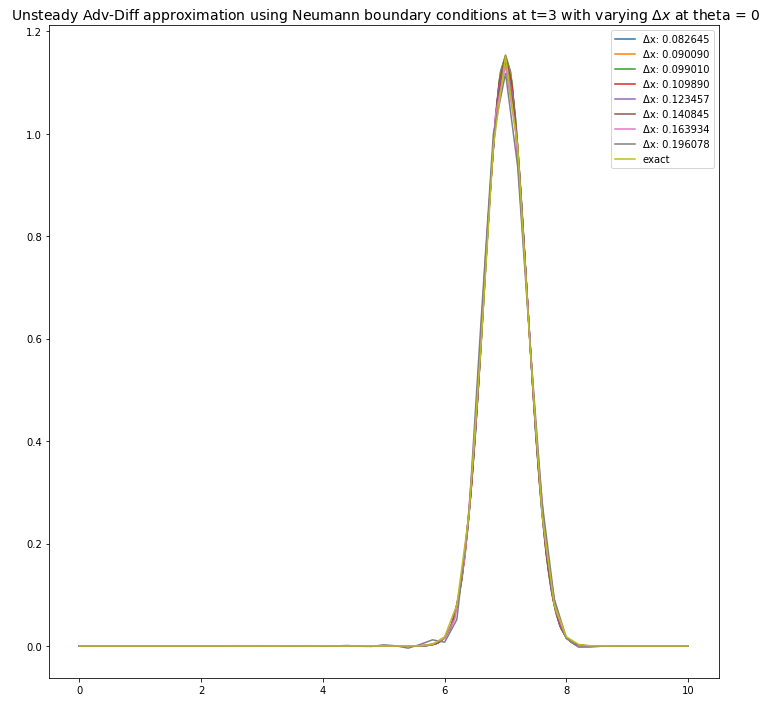

In [53]:

N_nodes_CG = 121
Lx = 10. # Cell width
# Reaction conditions
kappa = 1./100.
U = 1. 
#numerical parameters
N_loc = 2 # number of local nodes per element
N_gi = 3 # quadrature points
# time stepping
dt = 0.0004
t = 2.
t_end = t + 4.
track_err_FE_FEM = []
x_mesh= []
fig, ax1 = plt.subplots(1, 1, figsize=(12, 12))
while N_nodes_CG > 41: # 1
    x_mesh.append(Lx/N_nodes_CG)
    C_exact, u, x_nodes = rms_fem(dt,N_gi, N_nodes_CG, 0., bc_option = 1)
    err = rmse(C_exact, u)
    track_err_FE_FEM.append(err)
    ax1.plot(x_nodes, u, label='Δx: {:.6f}'.format(Lx/N_nodes_CG))
    N_nodes_CG -= 10# 25
ax1.plot(x_nodes, C_exact, label='exact')    
ax1.legend(loc ='best')
ax1.set_title(' Unsteady Adv-Diff approximation using Neumann boundary conditions at t=3 with varying $\Delta x$ at theta = 0', fontsize=14)

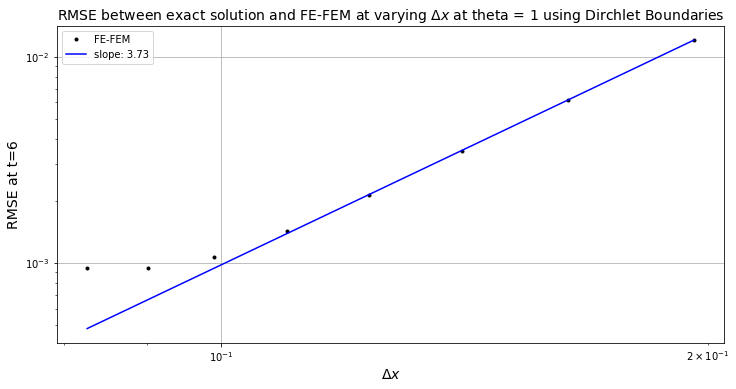

In [54]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))

fig.tight_layout(w_pad=4, h_pad=5)
ax1.loglog(x_mesh,  track_err_FE_FEM, 'k.', label='FE-FEM')

start_fit = 4

ax1.set_xlabel('$\Delta x$', fontsize=14)
ax1.set_ylabel('RMSE at t=6', fontsize=14)
ax1.set_title('RMSE between exact solution and FE-FEM at varying $\Delta x$ at theta = 1 using Dirchlet Boundaries', fontsize=14)
ax1.grid(True)

line_fit_fe_fem = np.polyfit(np.log(x_mesh[start_fit:]), np.log(track_err_FE_FEM[start_fit:]), 1)
ax1.loglog(x_mesh, np.exp(line_fit_fe_fem[1]) * x_mesh**(line_fit_fe_fem[0]), 'b-', label = 'slope: {:.2f}'.format(line_fit_fe_fem[0]))
ax1.legend(loc='best')

r parameter:  0.004000000000000171
r parameter:  0.0036100000000000385
r parameter:  0.0032400000000000232
r parameter:  0.0028900000000000206
r parameter:  0.00256
r parameter:  0.002250000000000016
r parameter:  0.001960000000000014
r parameter:  0.001690000000000012
r parameter:  0.001440000000000041
r parameter:  0.001210000000000026
r parameter:  0.0010000000000000072
r parameter:  0.0008100000000000058
r parameter:  0.00064
r parameter:  0.0004900000000000035
r parameter:  0.00036000000000000257
r parameter:  0.0002500000000000018


Text(0.5, 1.0, ' Unsteady Adv-Diff approximation using Neumann boundary conditions at t=3 with varying $\\Delta x$ at theta = 0.5')

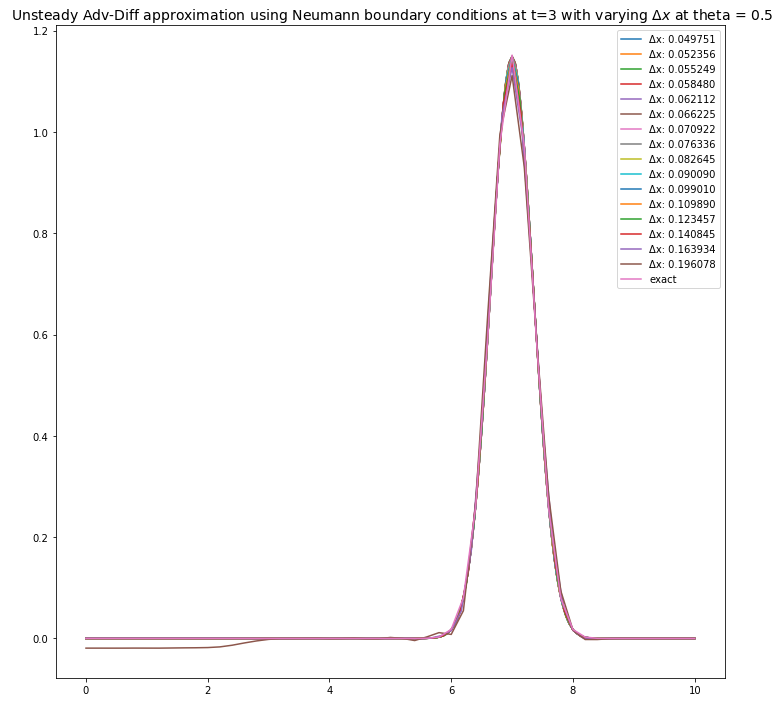

In [55]:
#N_nodes_CG = 301
N_nodes_CG = 201
Lx = 10. # Cell width
# Reaction conditions
kappa = 1./100.
U = 1. 
#numerical parameters
N_loc = 2 # number of local nodes per element
N_gi = 3 # quadrature points
# time stepping
dt = 0.001
t = 2.
t_end = t + 4.
track_err_crank_FEM = []
x_mesh= []
fig, ax1 = plt.subplots(1, 1, figsize=(12, 12))
while N_nodes_CG > 41:
    x_mesh.append(Lx/N_nodes_CG)
    C_exact, u, x_nodes = rms_fem(dt,N_gi, N_nodes_CG, 0.5, bc_option = 0)
    err = rmse(C_exact, u)
    track_err_crank_FEM.append(err)
    ax1.plot(x_nodes, u, label='Δx: {:.6f}'.format(Lx/N_nodes_CG))
    N_nodes_CG -= 10
ax1.plot(x_nodes, C_exact, label='exact')    
ax1.legend(loc ='best')
ax1.set_title(' Unsteady Adv-Diff approximation using Neumann boundary conditions at t=3 with varying $\Delta x$ at theta = 0.5', fontsize=14)

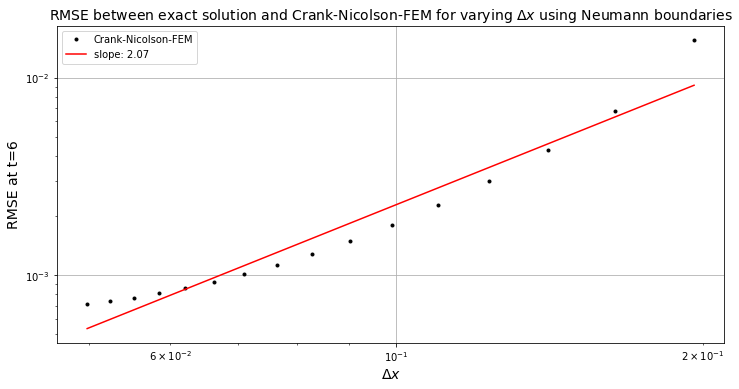

In [56]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))

fig.tight_layout(w_pad=4, h_pad=5)
ax1.loglog(x_mesh,  track_err_crank_FEM, 'k.', label='Crank-Nicolson-FEM')

start_fit = 0

ax1.set_xlabel('$\Delta x$', fontsize=14)
ax1.set_ylabel('RMSE at t=6', fontsize=14)
ax1.set_title('RMSE between exact solution and Crank-Nicolson-FEM for varying $\Delta x$ using Neumann boundaries', fontsize=14)
ax1.grid(True)

line_fit_crank_fem = np.polyfit(np.log(x_mesh[start_fit:]), np.log( track_err_crank_FEM[start_fit:]), 1)
ax1.loglog(x_mesh, np.exp( line_fit_crank_fem[1]) * x_mesh**( line_fit_crank_fem[0]), 'r-', label = 'slope: {:.2f}'.format(line_fit_crank_fem[0]))
ax1.legend(loc='best')

Crankn-Nicolson-FEM has an asymptote at a smaller rmse than fe-FEM or be-FEM. This explains the better visual overlap between the exact and the Crank-Nicolson-FEM approximation. The slope however, is similar to that of FE-FEM and BE-FEM. This suggests that the spatial error relating to the FEM method for the advection diffusion equation is the same for all 3 methods as it is in FDM. The difference being however, the slope is more than double that when using FDM. 

r parameter:  0.004000000000000171
r parameter:  0.0036100000000000385
r parameter:  0.0032400000000000232
r parameter:  0.0028900000000000206
r parameter:  0.00256
r parameter:  0.002250000000000016
r parameter:  0.001960000000000014
r parameter:  0.001690000000000012
r parameter:  0.001440000000000041
r parameter:  0.001210000000000026
r parameter:  0.0010000000000000072
r parameter:  0.0008100000000000058
r parameter:  0.00064
r parameter:  0.0004900000000000035
r parameter:  0.00036000000000000257
r parameter:  0.0002500000000000018


Text(0.5, 1.0, ' Unsteady Adv-Diff approximation using Dirchlet boundary conditions at t=3 with varying $\\Delta x$ at theta = 0.5')

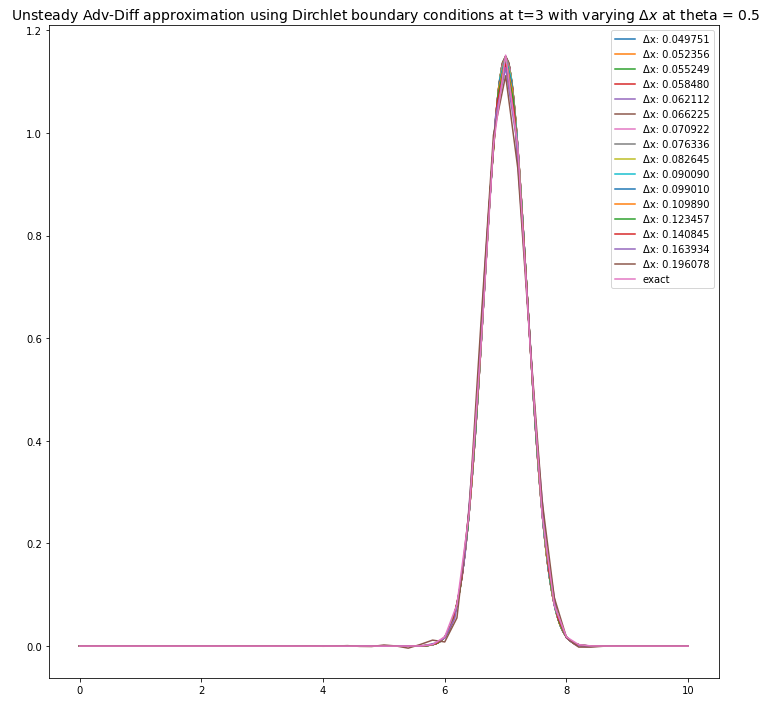

In [57]:
N_nodes_CG = 201
Lx = 10. # Cell width
# Reaction conditions
kappa = 1./100.
U = 1. 
#numerical parameters
N_loc = 2 # number of local nodes per element
N_gi = 3 # quadrature points
# time stepping
dt = 0.001
t = 2.
t_end = t + 4.

track_err_crank_FEM = []
x_mesh= []
fig, ax1 = plt.subplots(1, 1, figsize=(12, 12))
while N_nodes_CG > 41:
    x_mesh.append(Lx/N_nodes_CG)
    C_exact, u, x_nodes = rms_fem(dt,N_gi, N_nodes_CG, 0.5, bc_option = 1)
    err = rmse(C_exact, u)
    track_err_crank_FEM.append(err)
    ax1.plot(x_nodes, u, label='Δx: {:.6f}'.format(Lx/N_nodes_CG))
    N_nodes_CG -= 10
ax1.plot(x_nodes, C_exact, label='exact')    
ax1.legend(loc ='best')
ax1.set_title(' Unsteady Adv-Diff approximation using Dirchlet boundary conditions at t=3 with varying $\Delta x$ at theta = 0.5', fontsize=14)

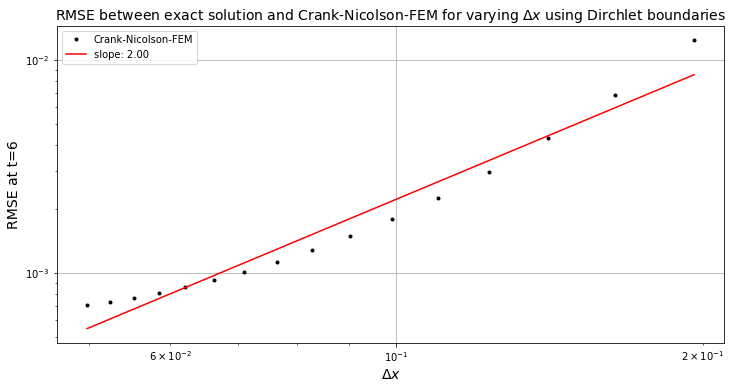

In [58]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))

fig.tight_layout(w_pad=4, h_pad=5)
ax1.loglog(x_mesh,  track_err_crank_FEM, 'k.', label='Crank-Nicolson-FEM')

start_fit = 0

ax1.set_xlabel('$\Delta x$', fontsize=14)
ax1.set_ylabel('RMSE at t=6', fontsize=14)
ax1.set_title('RMSE between exact solution and Crank-Nicolson-FEM for varying $\Delta x$ using Dirchlet boundaries', fontsize=14)
ax1.grid(True)

line_fit_crank_fem = np.polyfit(np.log(x_mesh[start_fit:]), np.log( track_err_crank_FEM[start_fit:]), 1)
ax1.loglog(x_mesh, np.exp( line_fit_crank_fem[1]) * x_mesh**( line_fit_crank_fem[0]), 'r-', label = 'slope: {:.2f}'.format(line_fit_crank_fem[0]))
ax1.legend(loc='best')

r parameter:  0.32000000000003637
r parameter:  0.16000000000001818
r parameter:  0.08000000000000909


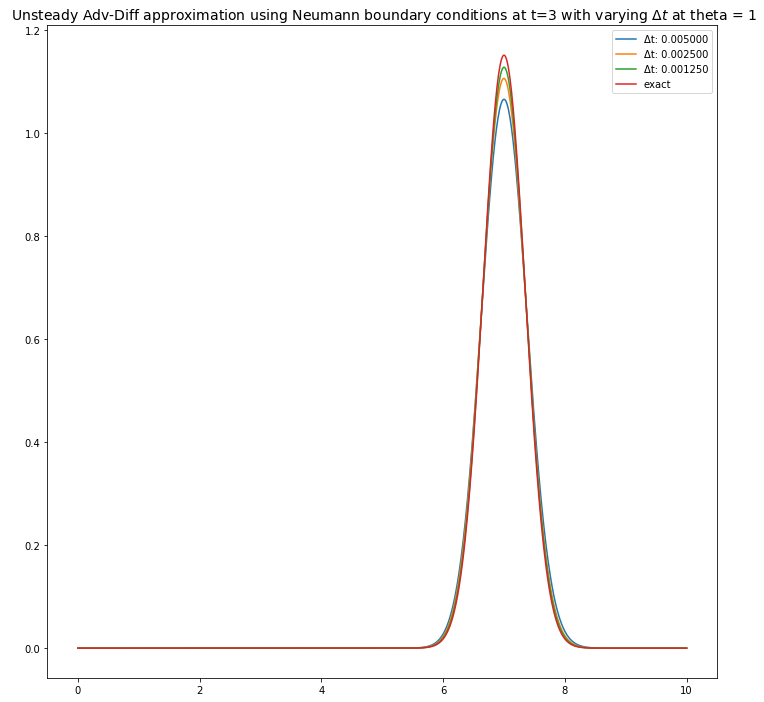

In [59]:
N_nodes_CG = 801
Lx = 10. # Cell width
# Reaction conditions
kappa = 1./100.
U = 1. 
#numerical parameters
N_loc = 2 # number of local nodes per element
N_gi = 3 # quadrature points
# time stepping
dt = 0.005
t = 2.
t_end = t + 4.
track_err_BE_FEM = []
t_mesh= []
fig, ax1 = plt.subplots(1, 1, figsize=(12, 12))
while dt > 0.001:
    t_mesh.append(dt)
    C_exact, u, x_nodes = rms_fem(dt,N_gi, N_nodes_CG, 1., bc_option = 0)
    err = rmse(C_exact, u)
    track_err_BE_FEM.append(err)
    ax1.plot(x_nodes, u, label='Δt: {:.6f}'.format(dt))
    dt *= 0.5
ax1.plot(x_nodes, C_exact, label='exact')
ax1.set_title(' Unsteady Adv-Diff approximation using Neumann boundary conditions at t=3 with varying $\Delta t$ at theta = 1', fontsize=14)
ax1.legend(loc='best')    

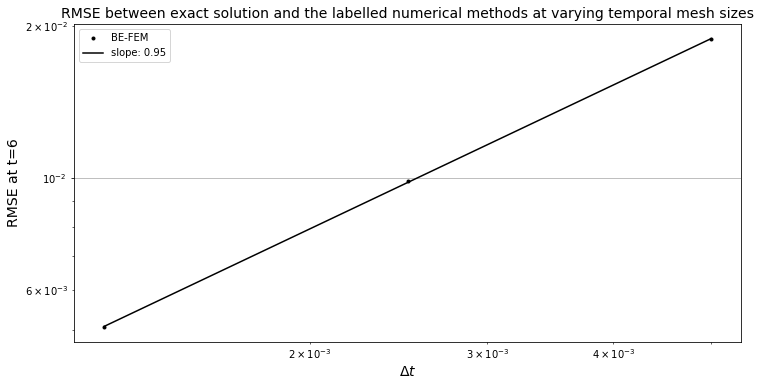

In [60]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))

fig.tight_layout(w_pad=4, h_pad=5)
ax1.loglog(t_mesh,  track_err_BE_FEM, 'k.', label='BE-FEM')

start_fit = 0

ax1.set_xlabel('$\Delta t$', fontsize=14)
ax1.set_ylabel('RMSE at t=6', fontsize=14)
ax1.set_title('RMSE between exact solution and the labelled numerical methods at varying temporal mesh sizes', fontsize=14)
ax1.grid(True)

line_fit_be_fem = np.polyfit(np.log(t_mesh[start_fit:]), np.log(track_err_BE_FEM[start_fit:]), 1)

ax1.loglog(t_mesh, np.exp(line_fit_be_fem[1]) * t_mesh**(line_fit_be_fem[0]), 'k-', label = 'slope: {:.2f}'.format(line_fit_be_fem[0]))
ax1.legend(loc='best')

r parameter:  0.5000000000000213
r parameter:  0.25000000000001066
r parameter:  0.12500000000000533


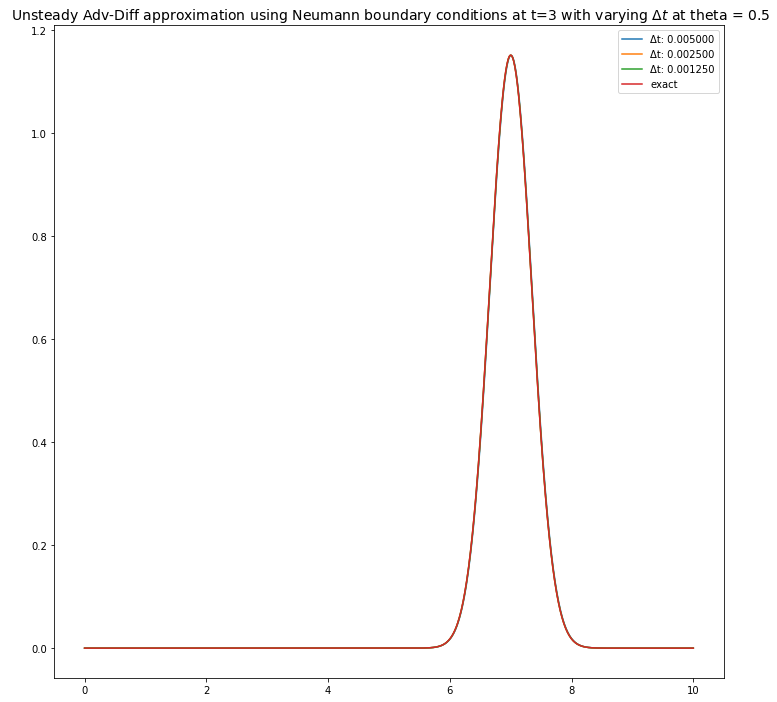

In [61]:
N_nodes_CG = 1001
Lx = 10. # Cell width
# Reaction conditions
kappa = 1./100.
U = 1. 
#numerical parameters
N_loc = 2 # number of local nodes per element
N_gi = 3 # quadrature points
# time stepping
dt = 0.005
t = 2.
t_end = t + 4.
track_err_crank_FEM = []
t_mesh= []
fig, ax1 = plt.subplots(1, 1, figsize=(12, 12))
while dt > 0.001:
    t_mesh.append(dt)
    C_exact, u, x_nodes = rms_fem(dt,N_gi, N_nodes_CG, 0.5, bc_option = 0)
    err = rmse(C_exact, u)
    track_err_crank_FEM.append(err)
    ax1.plot(x_nodes, u, label='Δt: {:.6f}'.format(dt))
    dt *= 0.5
ax1.plot(x_nodes, C_exact, label='exact')
ax1.set_title(' Unsteady Adv-Diff approximation using Neumann boundary conditions at t=3 with varying $\Delta t$ at theta = 0.5', fontsize=14)
ax1.legend(loc='best')      

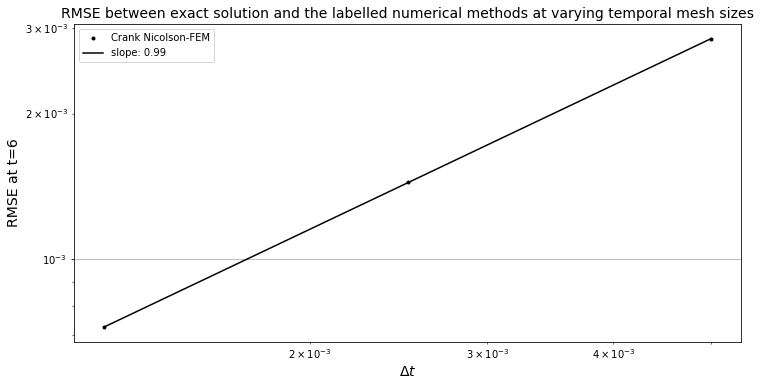

In [62]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))

fig.tight_layout(w_pad=4, h_pad=5)
ax1.loglog(t_mesh,  track_err_crank_FEM, 'k.', label='Crank Nicolson-FEM')

start_fit = 0

ax1.set_xlabel('$\Delta t$', fontsize=14)
ax1.set_ylabel('RMSE at t=6', fontsize=14)
ax1.set_title('RMSE between exact solution and the labelled numerical methods at varying temporal mesh sizes', fontsize=14)
ax1.grid(True)

line_fit_crank_fem = np.polyfit(np.log(t_mesh[start_fit:]), np.log(track_err_crank_FEM[start_fit:]), 1)


ax1.loglog(t_mesh, np.exp(line_fit_crank_fem[1]) * t_mesh**(line_fit_crank_fem[0]), 'k-', label = 'slope: {:.2f}'.format(line_fit_crank_fem[0]))
ax1.legend(loc='best')

r parameter:  0.12500000000000533
r parameter:  0.06250000000000266
r parameter:  0.03125000000000133


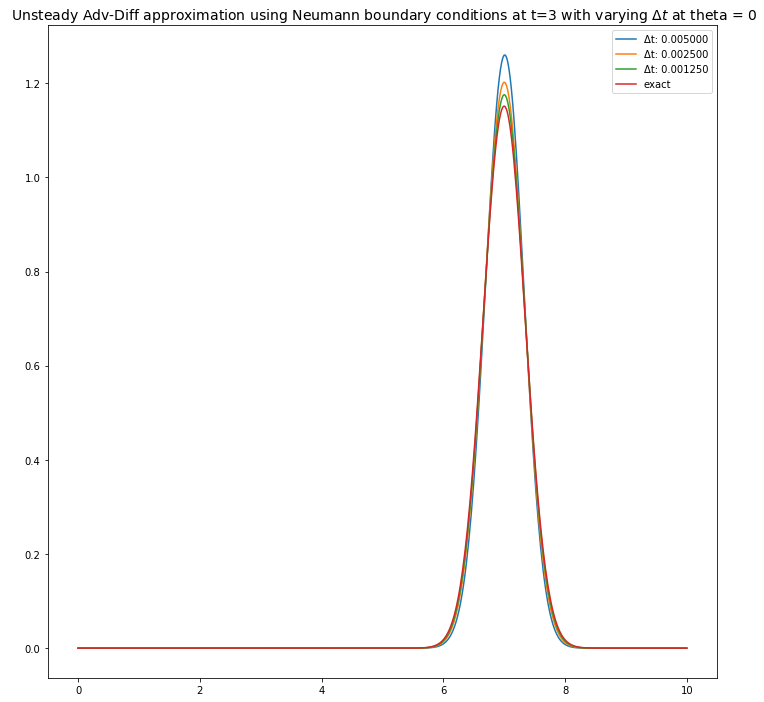

In [63]:
N_nodes_CG = 501
Lx = 10. # Cell width
# Reaction conditions
kappa = 1./100.
U = 1. 
#numerical parameters
N_loc = 2 # number of local nodes per element
N_gi = 3 # quadrature points
# time stepping
dt = 0.005
t = 2.
t_end = t + 4.
track_err_FE_FEM = []
t_mesh= []
fig, ax1 = plt.subplots(1, 1, figsize=(12, 12))
while dt > 0.001:
    t_mesh.append(dt)
    C_exact, u, x_nodes = rms_fem(dt,N_gi, N_nodes_CG, 0., bc_option = 0)
    err = rmse(C_exact, u)
    track_err_FE_FEM.append(err)
    ax1.plot(x_nodes, u, label='Δt: {:.6f}'.format(dt))
    dt *= 0.5
ax1.plot(x_nodes, C_exact, label='exact')
ax1.set_title(' Unsteady Adv-Diff approximation using Neumann boundary conditions at t=3 with varying $\Delta t$ at theta = 0', fontsize=14)
ax1.legend(loc='best')      

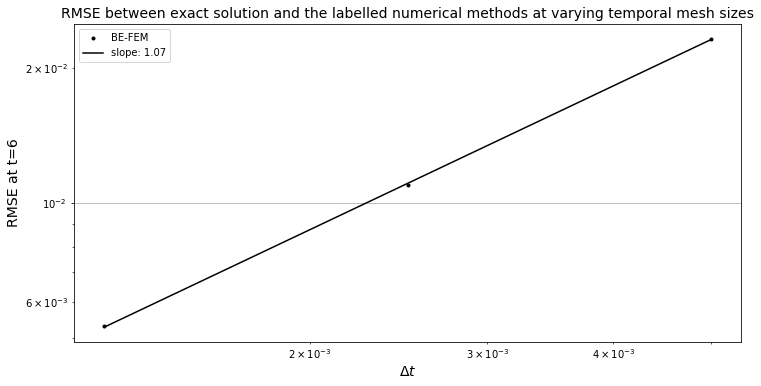

In [64]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))

fig.tight_layout(w_pad=4, h_pad=5)
ax1.loglog(t_mesh,  track_err_FE_FEM, 'k.', label='BE-FEM')

start_fit = 0

ax1.set_xlabel('$\Delta t$', fontsize=14)
ax1.set_ylabel('RMSE at t=6', fontsize=14)
ax1.set_title('RMSE between exact solution and the labelled numerical methods at varying temporal mesh sizes', fontsize=14)
ax1.grid(True)

line_fit_fe_fem = np.polyfit(np.log(t_mesh[start_fit:]), np.log(track_err_FE_FEM[start_fit:]), 1)

ax1.loglog(t_mesh, np.exp(line_fit_fe_fem[1]) * t_mesh**(line_fit_fe_fem[0]), 'k-', label = 'slope: {:.2f}'.format(line_fit_fe_fem[0]))
ax1.legend(loc='best')

All three methods for FEM demonstrate a slope of 1 when varying $\Delta t$. Compared to FDM, it is the same convergence order except for Crank-Nicolson CS which had a temporal convergence order of 2.

In [65]:
U = 1.
kappa = 1./100.
N = 500
L = 10.
dx = L / N
dt = 0.001
t_start = 2.
t_end = t_start + 4.
x0 = 1.0
#
Lx = 10. # Cell width
# Reaction conditions
#numerical parameters
N_loc = 2 # number of local nodes per element
N_gi = 3 # quadrature points
# number of global nodes
N_nodes_CG = 500


%timeit  FEM(0.5, Lx, kappa, U, N_loc, N_gi, t, dt, t_end, N_nodes_CG, bc_option = 0)


%timeit  solve_adv_diff_Gaussian_theta(N, dt, t_start, t_end, U, kappa, theta=0.5)

N_gi = 2
%timeit FEM(0.5, Lx, kappa, U, N_loc, N_gi, t, dt, t_end, N_nodes_CG, bc_option = 0)

N_gi = 3
%timeit FEM(0., Lx, kappa, U, N_loc, N_gi, t, dt, t_end, N_nodes_CG,  bc_option = 0)


%timeit solve_adv_diff_Gaussian_theta(N, dt, t_start, t_end, U, kappa, theta = 0.)

N_gi = 2
%timeit FEM(0., Lx, kappa, U, N_loc, N_gi, t, dt, t_end, N_nodes_CG,  bc_option = 0)

N_gi = 3
%timeit FEM(1., Lx, kappa, U, N_loc, N_gi, t, dt, t_end, N_nodes_CG,  bc_option = 0)

%timeit solve_adv_diff_Gaussian_theta(N, dt, t_start, t_end, U, kappa, theta = 1.)

N_gi = 2
%timeit FEM(1., Lx, kappa, U, N_loc, N_gi, t, dt, t_end, N_nodes_CG,  bc_option = 0)

When i tested the time taken for the FDM and FEM with different quadrature methods which appeared faster varied each time and thus i have left them as markdown cells. However, when N_gi = 3 it should theoretically take longer than when N_gi = 2 as the for loop in the FEM function has a greater range to loop over. Comparing FDM and FEM is not entirely appropriate given FDM is vectorised while FEM employs many for loops.

In [66]:
print("FDM RMSE, Crank-Nicolson-CS at t=6 is :{}".format(RMSE_ERROR_FDM(dt, N, U, kappa, theta=0.5)))

FDM RMSE, Crank-Nicolson-CS at t=6 is :0.0031556868399768363


In [67]:
N_gi = 3
C_exact, u, x_nodes = rms_fem(dt, N_gi, N_nodes_CG, theta=0.5)
print(f"FEM RMSE, Crank Nicolson at t=6 and using Simpson's is :{rmse(C_exact, u)}")

r parameter:  0.024900100000003814
FEM RMSE, Crank Nicolson at t=6 and using Simpson's is :0.0005851810376658159


In [68]:
N_gi = 2
C_exact, u, x_nodes = rms_fem(dt, N_gi, N_nodes_CG, theta=0.5)
print(f"FEM RMSE, Crank Nicolson at t=6 and using trapezoidal is :{rmse(C_exact, u)}")

r parameter:  0.024900100000003814
FEM RMSE, Crank Nicolson at t=6 and using trapezoidal is :0.002100003231191563


In [69]:
print(f"FDM RMSE, FTCS at t = 6 is :{RMSE_ERROR_FDM(dt, N, U, kappa, theta=0.)}")

FDM RMSE, FTCS at t = 6 is :0.005132098134751744


In [70]:
N_gi = 3
C_exact, u, x_nodes = rms_fem(dt, N_gi, N_nodes_CG, theta=0.)
print(f"FEM RMSE, FE-FEM at t = 6 and using Simpson's is :{rmse(C_exact, u)}")

r parameter:  0.024900100000003814
FEM RMSE, FE-FEM at t = 6 and using Simpson's is :0.004212827706225401


In [71]:
N_gi = 2
C_exact, u, x_nodes = rms_fem(dt, N_gi, N_nodes_CG, theta=0.)
print(f"FEM RMSE, FE-FEM at t = 6 and using trapezoidal is is :{rmse(C_exact, u)}")

r parameter:  0.024900100000003814
FEM RMSE, FE-FEM at t = 6 and using trapezoidal is is :0.004590816460867528


In [72]:
print(f"FDM RMSE, BTCS at t=6 is :{RMSE_ERROR_FDM(dt, N, U, kappa, theta=1.)}")

FDM RMSE, BTCS at t=6 is :0.00523720627884626


In [73]:
N_gi = 3
C_exact, u, x_nodes = rms_fem(dt, N_gi, N_nodes_CG, theta=1.)
print(f"FEM RMSE, BE-FEM at t = 6 and using Simpson's is {rmse(C_exact, u)}")

r parameter:  0.024900100000003814
FEM RMSE, BE-FEM at t = 6 and using Simpson's is 0.004112408470119096


In [74]:
N_gi = 2
C_exact, u, x_nodes = rms_fem(dt, N_gi, N_nodes_CG, theta=1.)
print(f"FEM RMSE, BE-FEM at t = 6 and using trapezoidal is {rmse(C_exact, u)}")

r parameter:  0.024900100000003814
FEM RMSE, BE-FEM at t = 6 and using trapezoidal is 0.0046466584106914875


Using a fixed cell length of 10 and x mesh spacing of 500 for both methods with a fixed $\Delta t$ value of 0.001, the FEM simpson's method at t = 6 had the lowest error, followed by FEM trapezoidal and FDM. The difference in error is more visible when using the crank-nicolson method when theta = 0.5. This is expected due to crank-nicolson being a combination of both FE and BE (not average) and so more calculations at each timestep are required.

\begin{align*}
\text{Error in}\: T_{n} \leqslant \frac{M(b-a)^{3}}{12n^{2}}\: (1)
\end{align*}

\begin{align*}
\text{Error in}\: S_{n} \leqslant \frac{M(b-a)^{5}}{180n^{4}}\: (2)
\end{align*}

The error bound for the trapezoidal rule is given by equation 1 and the error bound bound given for Simpson's rule by equation 2.

Both methods are an approximation of an integral. The trapezoidal rule can over-estimate the integral if concave up or under-estimate if concave down. If the interval is equal then:
\begin{align*}
T_{n} = \frac{\Delta x}{2}(y_{1} + 2y_{2} + 2y_{3} + .. + 2y_{n-1} + y_{n}) \: (3) \\[10pt]
\end{align*}


Simpsons rule only applies when n is even:
\begin{align*}
S_{n} = \frac{\Delta x}{3}(y_{0} + 4y_{1} + 2y_{2} + 4y_{3} + 2y_{4} + ... 2y_{n-2} + 4y_{n-1} + y_{n}) \: (4)
\end{align*}

Simpson's rule is a weighted average of the midpoint and trapezoidal rules. Therefore, more function evaluations are required and so it takes longer to compute.

Simpson's order of n is twice that of the n term in the trapezoidal bound, error is inversely proportional to n. In addition, the error is asympototically proportional to the $(b-a)^{n}$ term where n = 3 for trapezodial and n = 5 for simpson's rule. Equation 1 and 2 demonstrates that Simpson's is more accurate and converges closer to the true definite integral. In fact, simpson's rule can give exact results for a polynomial with a degree of 3 or less.

When using Simpson's to calculate the integrand the time taken for the FEM function to complete for any value of theta(0, 0.5, 1) took longer than when trapezoidal was used.

Which method is better to approximate the bounded integral depends on the smoothness of the function. For 'rougher' functions, the trapezodial rule has a faster convergence than Simpson's. Given the analytical solution had a guassian form, using guassian quarature would be more accurate and the better choice if only accuracy is important and time taken is not a condition. However, in this specific case given the time difference isn't huge then choosing simpson's the most accurate method is favoured.

CONCLUSION FOR Q3

- When using the same parameters with varying theta results, the error was much lower when using theta = 0.5, this is seen for both FEM and FDM methods. This can be seen both graphically in the plots with titles ' Unsteady Adv-Diff approximation using Neumann boundary conditions at t=3 with varying $\Delta t$ at theta = z' where z is 0, 0.5 or 1 and numerically above. When theta = 0.5, FDM had an error of 0.00316 (5 d.p), Simpson's rule-FEM had an error of :0.00059 (5 d.p) and Trapezodial rule - FEM an error of 0.00210 (5 d.p). Across the board Simpson's rule-FEM outpeformed in terms of accuracy.

- The error associated with Simpson's quadrature and Trapezoidal quadrature FEM is larger for when theta = 1 and 0 with theta = 1 producing the largest errors for FDM. This is likely to BTCS using an iterative solver to solve the system of equations as it is an implicit equation. FTCS has no need for a solver so is more accurate but it is not unconditionally stable like BTCS. The error between BE-FEM and FE-FEM is marginal and the data does not suggest which is more accurate given when using Simpson's rule BE-FEM is more accurate but when using Trapezoidal rule FE-FEM is more accurate. More computational analysis would be required to confidently saw which one is more accurate at theta = 1 or 0 for FEM methods.

- Regarding the spatial convergence, when using Neumann boundary conditions the slope is smaller when using the same conditions but with Dirchlet Boundary Conditions.
This is likely due to the nature of the Dirchlet boundary conditions themselves where they are specified which would decrease the rate of convergence. With more greater quality meshes and smaller timesteps, the neumann condition would be more accurate as it is periodic and hence converge at a faster rate.

- At a fixed $\Delta t$ the error converges at the same rate to an asymptote for the FEM and FDM for when theta = 0.5 or 0 where the slope is defined by the error: $\mathcal{O}({\Delta x^2})$. However, it was difficult
proved diffcult to show the convergence error when theta = 0.5, even when using a poorer timestep. When theta = 1, the slope was much greater when the same parameters for when theta = 0 was used. In addition, it appeared to converge to the asymptote faster than when theta = 1.

- At a fixed $\Delta x$ the convergence order for $\Delta t$ was approximately 1 for all methods. This is expected for when theta = 0 or 1. However, when theta = 0.5 we would expect a convergence order of 2. It possible the choice of parameters chosen were not ideal to prove the convergence order of 2. Using larger timesteps instead may be a better option.

- The convergence orders for spatial are higher than that of the temporal. Improving the quality of the spacial mesh by increasing the number of global nodes and even potentially varying dx the rmse will decrease faster than when trying to alter $\Delta t$. However, stability parameters should be met such as the r parameter which is continually prinited out when the FEM function is called.

- FEM is more accurate using either the trapezoidal rule or Simpson's rule to calculate the integrand than FDM. The most accurate scheme being FEM using Simpson's rule.

- FEM given our conditions seems to take less time for when theta = 0 or 1 but longer when theta = 0.5. FDM is typically faster to compute, it is likely the time taken for such methods do not increase by the same order, such that when the quality of the mesh spacing is improved then one should expect FEM to take longer than FDM. The observation that when theta = 0.5 takes longer for FEM can be explained by the fact it is a combination of theta = 1 and theta = 0 and thus the while loop in FEM takes longer. In addition, it can also be explained by the order of time taken for the methods not being the same, as in the time taken for FEM to execute increases more dramatically than FDM.

- Overall FEM is better than FDM due to the lower RMSE errors and the time difference given our parameters actually show our FEM method to be quicker when theta = 0 or 1. Even for the case when theta = 0.5, the FEM method does not take that much longer than the FDM but offers a greater accuracy by an order of magnitude compared to FDM.

-  Approximating the function by piecewise linear offers room for flexibility on the weights and choice of basis functions. The mesh space can be refined depending on whether greater accuracy is required at different elements such as reducing $\Delta x$. This saves time but maintains accuracy when is needed. 

- Comparison of simpson's and trapezodial rule are completely valid as the same FEM function is used with the only difference being the quadrature.

- Using a tridiagonal matrix solver instead of a general SciPy would prove to be more computationally efficient.

- When theta = 0, FDM and FEM are conditionally stable. When theta = 0.5 or 1 FDM and FEM are unconditionally stable. However, for the diffusion term when theta = 0.5, the numerical approximation can contain errors in the form of osciilations if the Von stability Neumann stability analysis is not met. Unconditional stability is due to the equations taking an implicit form.

- In conclusion, FEM is a more flexible and more accurate method than FDM, useful theoretical results on errors and stability can be obtained for the solution function for FEM whilst FDM approximates the PDE/ODE function. Using the crank-nicolson method (theta = 0.5) in most cases is the preferred choice although if large time steps or a high spatial resolution is required then using the backwards euler method (theta = 1) would be the suitable choice. Even though it is not as accurate, it is unconditionally stable like crank-nicolson but also contains no oscillations which could result in large errors.

In [75]:
end = time.time()
print((end-start) * 0.0166667)

40.68189713489339
